# Regression with an Insurance Dataset (Model Training)
---
##### Source: **Kaggle Playground Prediction Competition**
##### Course Title: **DAMO-510-4: Winter 2025 Predictive Analytics**
##### Professor Name: **Professor Ali El-Sharif**
##### Submission Date: **March 9, 2025**
##### Submitted By:
1. **Denisse C. Cortes (NF1007936)**
2. **Dev D. Rabadia (NF1005560)**
3. **Miko L. Tan (NF1008647)**
4. **Rosario D. Torres (NF1001385)**

The data model for this project is a regression-based model designed to predict insurance premium amounts. The model uses a variety of features, including numerical variables (such as age, annual income, and health score) and categorical variables (such as gender, marital status, and policy type) to estimate the target variable: the insurance premium amount. The dataset incorporates several features with skewed distributions and missing values, which will be handled through appropriate preprocessing techniques. Outliers in the dataset, such as those found in the "Previous Claims" feature, will also be addressed to improve model accuracy and robustness.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [2]:
# Load the dataset
insurance_train_data = pd.read_csv('kaggle/input/playground-series-s4e12/train.csv')

Exploratory Data Analysis (EDA)
-----

In [3]:
insurance_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [4]:
# Check for nulls
# insurance_train_data.isna().sum()

# Assuming 'insurance_train_data' is your dataset
missing_data = insurance_train_data.isnull().sum()

# Calculate percentage of missing data
missing_percentage = (missing_data / len(insurance_train_data)) * 100

# Create a dataframe to store the missing data information
missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage,
})

# Define categories for missing percentage
def categorize_missing_data(percentage):
    if percentage <= 5:
        return 'Small (1-5%)'
    elif 5 < percentage <= 20:
        return 'Moderate (5-20%)'
    elif 20 < percentage <= 40:
        return 'High (20-40%)'
    else:
        return 'Very High (40%+)'

# Apply the categorization function
missing_info['Classification'] = missing_info['Missing Percentage'].apply(categorize_missing_data)

# Sort by missing percentage in descending order for better visibility
missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)

# Display the result
print(missing_info)

                      Missing Count  Missing Percentage    Classification
Previous Claims              364029           30.335750     High (20-40%)
Occupation                   358075           29.839583     High (20-40%)
Credit Score                 137882           11.490167  Moderate (5-20%)
Number of Dependents         109672            9.139333  Moderate (5-20%)
Customer Feedback             77824            6.485333  Moderate (5-20%)
Health Score                  74076            6.173000  Moderate (5-20%)
Annual Income                 44949            3.745750      Small (1-5%)
Age                           18705            1.558750      Small (1-5%)
Marital Status                18529            1.544083      Small (1-5%)
Vehicle Age                       6            0.000500      Small (1-5%)
Insurance Duration                1            0.000083      Small (1-5%)
Gender                            0            0.000000      Small (1-5%)
id                                0   

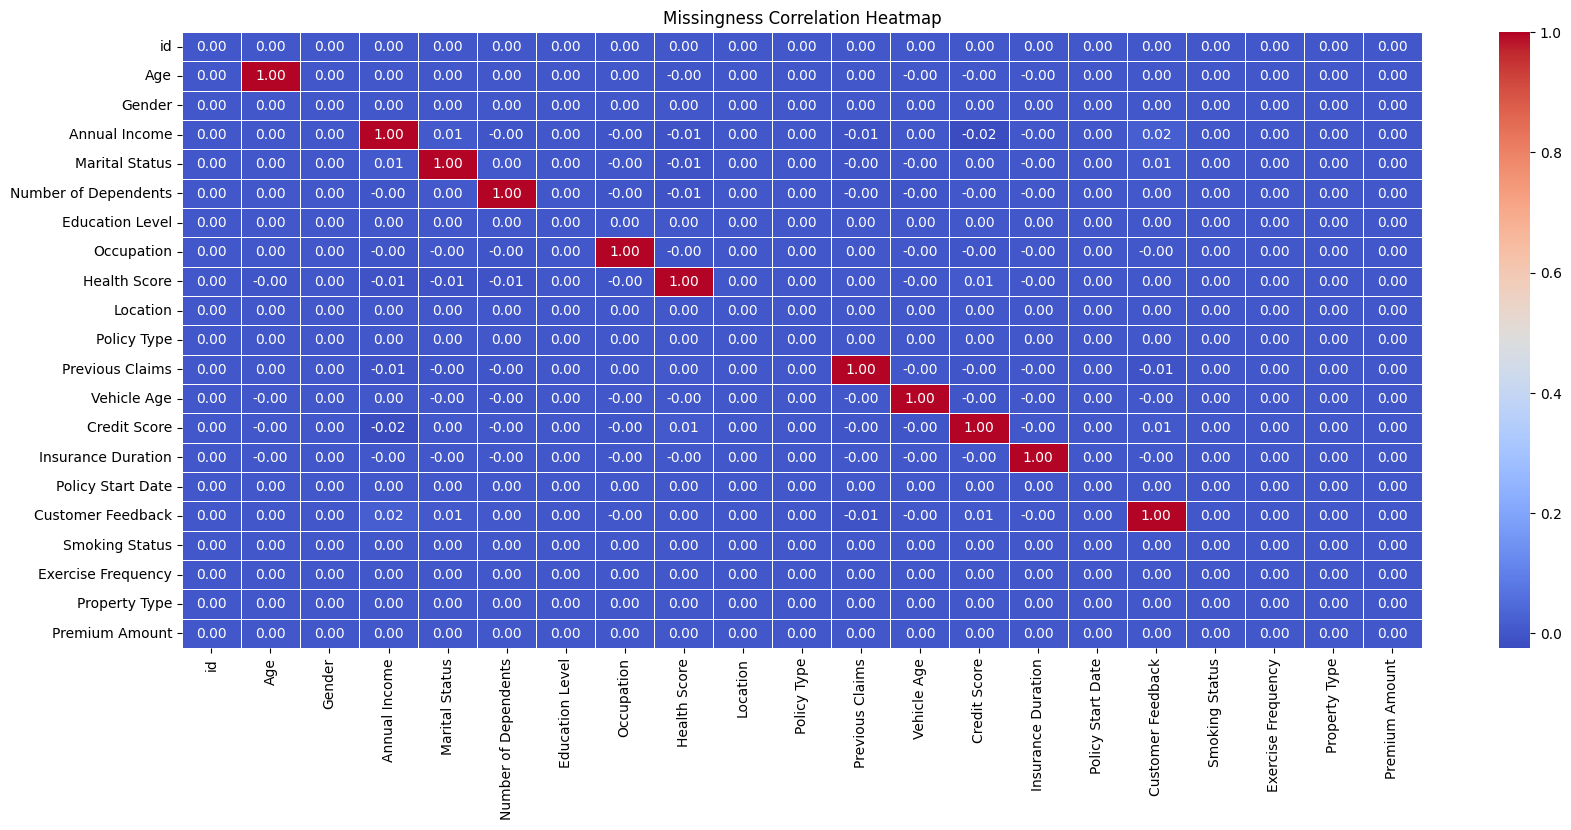

In [5]:
# Missingness Analysis (v2)
# Identify which variables tend to have missing values at the same time
# Create a DataFrame with missingness indicator (1 for missing, 0 for not missing)
missing_data = insurance_train_data.isnull().astype(int)

# Calculate the correlation matrix of the missingness
corr_matrix = missing_data.corr()
# Fill NaN values before plotting
corr_matrix = corr_matrix.fillna(0)
plt.figure(figsize=(20, 8)) 

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt='.2f')
plt.title("Missingness Correlation Heatmap")
plt.show()

In [6]:
# Check for duplicate rows
insurance_train_data.duplicated().sum()

np.int64(0)

In [7]:
insurance_train_data.nunique()

id                      1200000
Age                          47
Gender                        2
Annual Income             88593
Marital Status                3
Number of Dependents          5
Education Level               4
Occupation                    3
Health Score             532657
Location                      3
Policy Type                   3
Previous Claims              10
Vehicle Age                  20
Credit Score                550
Insurance Duration            9
Policy Start Date        167381
Customer Feedback             3
Smoking Status                2
Exercise Frequency            4
Property Type                 3
Premium Amount             4794
dtype: int64

In [8]:
# Describe the dataset
# insurance_train_data.describe()

# Apply styling to the describe output
styled_description = insurance_train_data.describe(include='all').style \
    .format({
        'Age': '{:.0f}',
        'Annual Income': '{:.2f}',
        'Number of Dependents': '{:.0f}',
        'Health Score': '{:.0f}',
        'Previous Claims': '{:.2f}',
        'Vehicle Age': '{:.0f}',
        'Credit Score': '{:.0f}',
        'Insurance Duration': '{:.2f}',
        'Premium Amount': '{:.2f}',
    }) \
    .map(lambda x: 'color: green' if isinstance(x, (int, float)) and x < 0 else '', subset=['Premium Amount'])

# Display the styled description
styled_description

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
count,1200000.000000,1181295,1200000,1155051.00,1181471,1090328,1200000,841925,1125924,1200000,1200000,835971.00,1199994,1062118,1199999.00,1200000,1122176,1200000,1200000,1200000,1200000.00
unique,nan,nan,2,nan,3,nan,4,3,nan,3,3,nan,nan,nan,nan,167381,3,2,4,3,nan
top,nan,nan,Male,nan,Single,nan,Master's,Employed,nan,Suburban,Premium,nan,nan,nan,nan,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,nan
freq,nan,nan,602571,nan,395391,nan,303818,282750,nan,401542,401846,nan,nan,nan,nan,142,377905,601873,306179,400349,nan
mean,599999.500000,41,nan,32745.22,nan,2,nan,nan,26,nan,nan,1.00,10,593,5.02,nan,nan,nan,nan,nan,1102.54
std,346410.305851,14,nan,32179.51,nan,1,nan,nan,12,nan,nan,0.98,6,150,2.59,nan,nan,nan,nan,nan,865.00
min,0.000000,18,nan,1.00,nan,0,nan,nan,2,nan,nan,0.00,0,300,1.00,nan,nan,nan,nan,nan,20.00
25%,299999.750000,30,nan,8001.00,nan,1,nan,nan,16,nan,nan,0.00,5,468,3.00,nan,nan,nan,nan,nan,514.00
50%,599999.500000,41,nan,23911.00,nan,2,nan,nan,25,nan,nan,1.00,10,595,5.00,nan,nan,nan,nan,nan,872.00
75%,899999.250000,53,nan,44634.00,nan,3,nan,nan,35,nan,nan,2.00,15,721,7.00,nan,nan,nan,nan,nan,1509.00


In [9]:
# Check sample values
insurance_train_data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


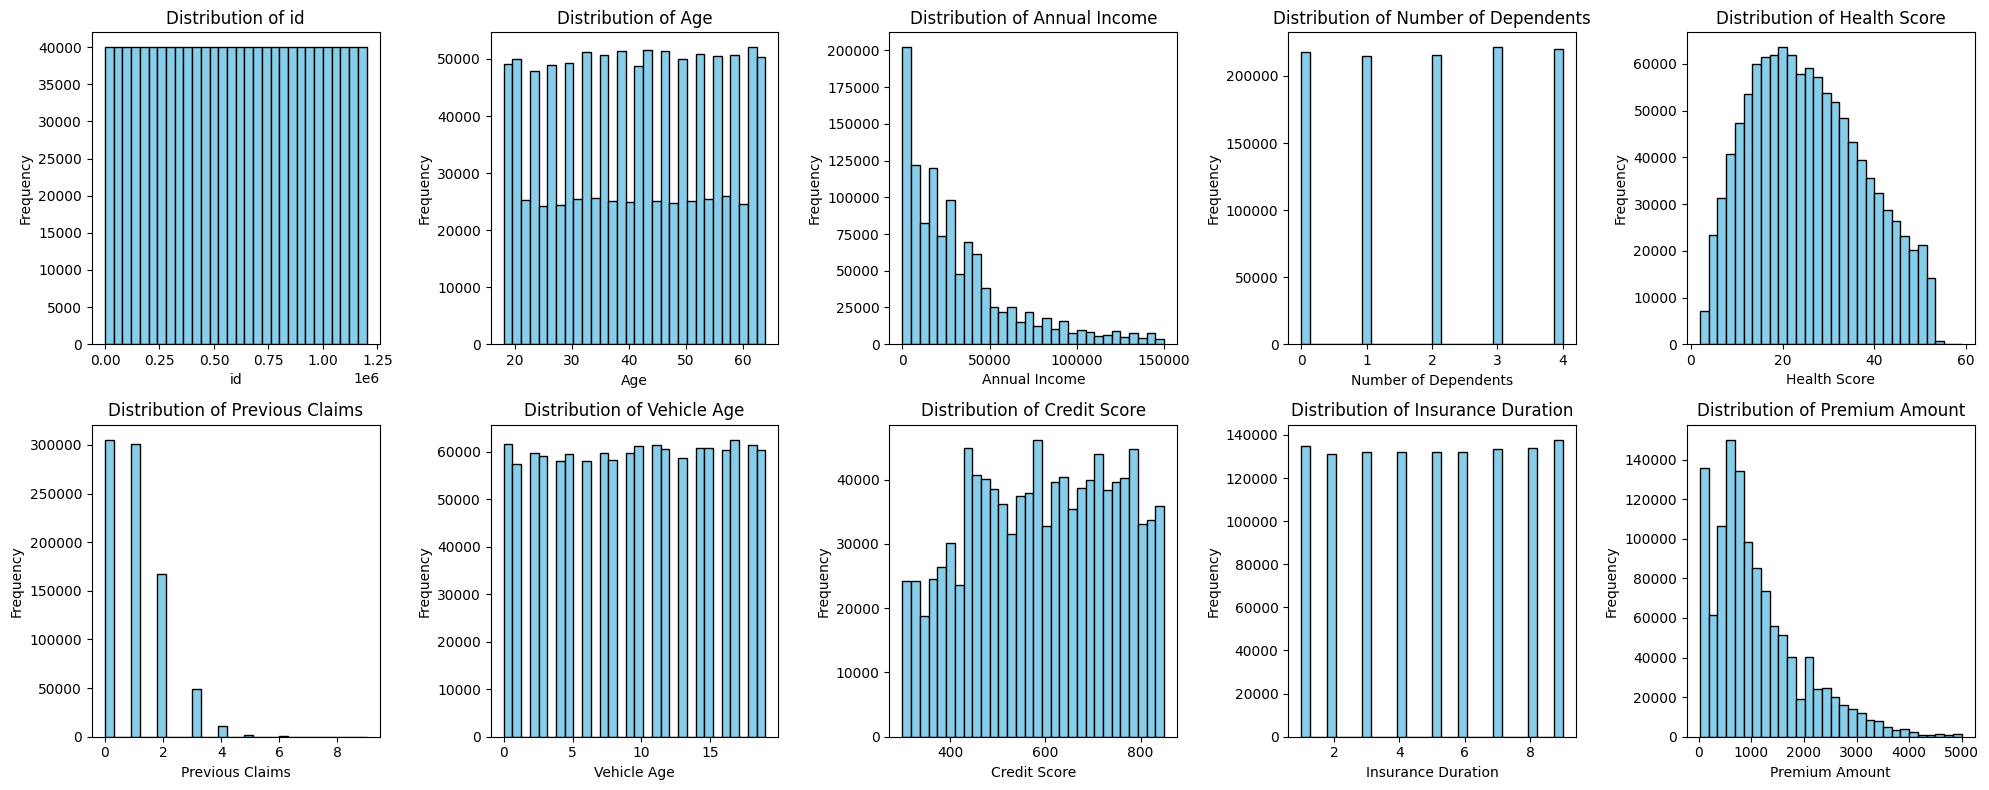

In [10]:
# Check distribution of numerical features
# Get numerical columns
num_columns = insurance_train_data.select_dtypes(include=['number']).columns

# Define grid size (5 columns)
num_cols = 5
num_rows = (len(num_columns) // num_cols) + (len(num_columns) % num_cols > 0)

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 4 * num_rows))  # Adjust height based on the number of rows

# Loop through numerical columns and plot histograms
for i, col in enumerate(num_columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Position plot in a 4x5 grid
    plt.hist(insurance_train_data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [11]:
# Skewness Computation with Interpretation
# Select only numerical columns
numerical_columns = insurance_train_data.select_dtypes(include=['number'])

# Compute skewness
skew_values = numerical_columns.skew().sort_values(ascending=False)

# Create a DataFrame to store skewness values
skew_df = pd.DataFrame({'Skewness Value': skew_values})

# Apply interpretation directly
skew_df['Interpretation'] = ""

skew_df.loc[skew_df['Skewness Value'] == 0, 'Interpretation'] = "Norm Dist (γ₁ = 0)"
skew_df.loc[(skew_df['Skewness Value'] > -0.5) & (skew_df['Skewness Value'] < 0.5), 'Interpretation'] = "Min/No Skew (γ₁ = -0.5 to 0.5)"
skew_df.loc[skew_df['Skewness Value'] > 1, 'Interpretation'] = "Extreme Right-Skewed (γ₁ > 1)"
skew_df.loc[skew_df['Skewness Value'] < -1, 'Interpretation'] = "Extreme Left-Skewed (γ₁ < -1)"
skew_df.loc[(skew_df['Skewness Value'] >= 0.5) & (skew_df['Skewness Value'] <= 1), 'Interpretation'] = "Right-Skewed (γ₁ > 0.5)"
skew_df.loc[(skew_df['Skewness Value'] <= -0.5) & (skew_df['Skewness Value'] >= -1), 'Interpretation'] = "Left-Skewed (γ₁ < -0.5)"

# Display the skewness table
print(skew_df)

                      Skewness Value                  Interpretation
Annual Income           1.470357e+00   Extreme Right-Skewed (γ₁ > 1)
Premium Amount          1.240915e+00   Extreme Right-Skewed (γ₁ > 1)
Previous Claims         9.053210e-01         Right-Skewed (γ₁ > 0.5)
Health Score            2.821873e-01  Min/No Skew (γ₁ = -0.5 to 0.5)
id                      3.836279e-16  Min/No Skew (γ₁ = -0.5 to 0.5)
Insurance Duration     -8.793302e-03  Min/No Skew (γ₁ = -0.5 to 0.5)
Age                    -1.253192e-02  Min/No Skew (γ₁ = -0.5 to 0.5)
Number of Dependents   -1.325461e-02  Min/No Skew (γ₁ = -0.5 to 0.5)
Vehicle Age            -2.040888e-02  Min/No Skew (γ₁ = -0.5 to 0.5)
Credit Score           -1.135726e-01  Min/No Skew (γ₁ = -0.5 to 0.5)


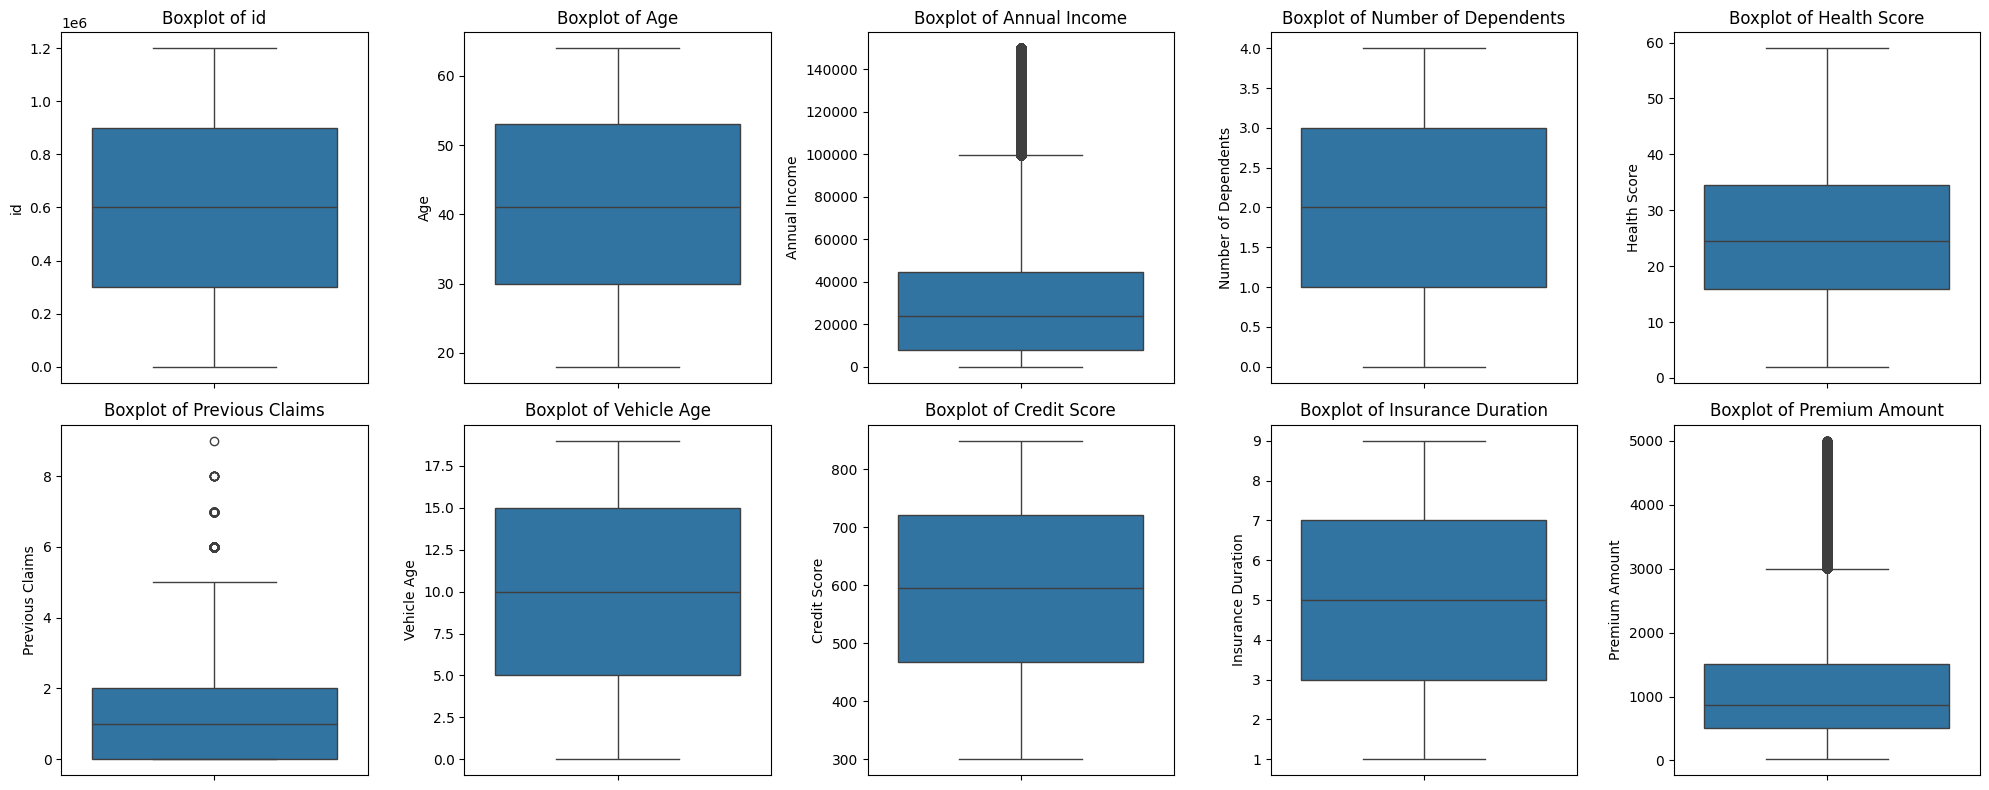

In [12]:
# Boxplots for outlier detection

# Get numerical columns
num_columns = insurance_train_data.select_dtypes(include=['number']).columns

# Define grid size (5 columns)
num_cols = 5
num_rows = (len(num_columns) // num_cols) + (len(num_columns) % num_cols > 0)

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 4 * num_rows))  # Adjust height based on the number of rows

# Loop through numerical columns and create boxplots
for i, col in enumerate(num_columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Position plot in a 4x5 grid
    sns.boxplot(y=insurance_train_data[col])
    plt.title(f"Boxplot of {col}")
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [13]:
# Print unique values for categorical columns
for col in insurance_train_data.select_dtypes(include=["object"]).columns:
    unique_vals = insurance_train_data[col].dropna().unique()
    print(f"Column: {col}")
    print("Unique Values:", unique_vals)
    print("Number of Unique Values:", len(unique_vals))
    print("-" * 50)

Column: Gender
Unique Values: ['Female' 'Male']
Number of Unique Values: 2
--------------------------------------------------
Column: Marital Status
Unique Values: ['Married' 'Divorced' 'Single']
Number of Unique Values: 3
--------------------------------------------------
Column: Education Level
Unique Values: ["Bachelor's" "Master's" 'High School' 'PhD']
Number of Unique Values: 4
--------------------------------------------------
Column: Occupation
Unique Values: ['Self-Employed' 'Employed' 'Unemployed']
Number of Unique Values: 3
--------------------------------------------------
Column: Location
Unique Values: ['Urban' 'Rural' 'Suburban']
Number of Unique Values: 3
--------------------------------------------------
Column: Policy Type
Unique Values: ['Premium' 'Comprehensive' 'Basic']
Number of Unique Values: 3
--------------------------------------------------
Column: Policy Start Date
Unique Values: ['2023-12-23 15:21:39.134960' '2023-06-12 15:21:39.111551'
 '2023-09-30 15:21:39

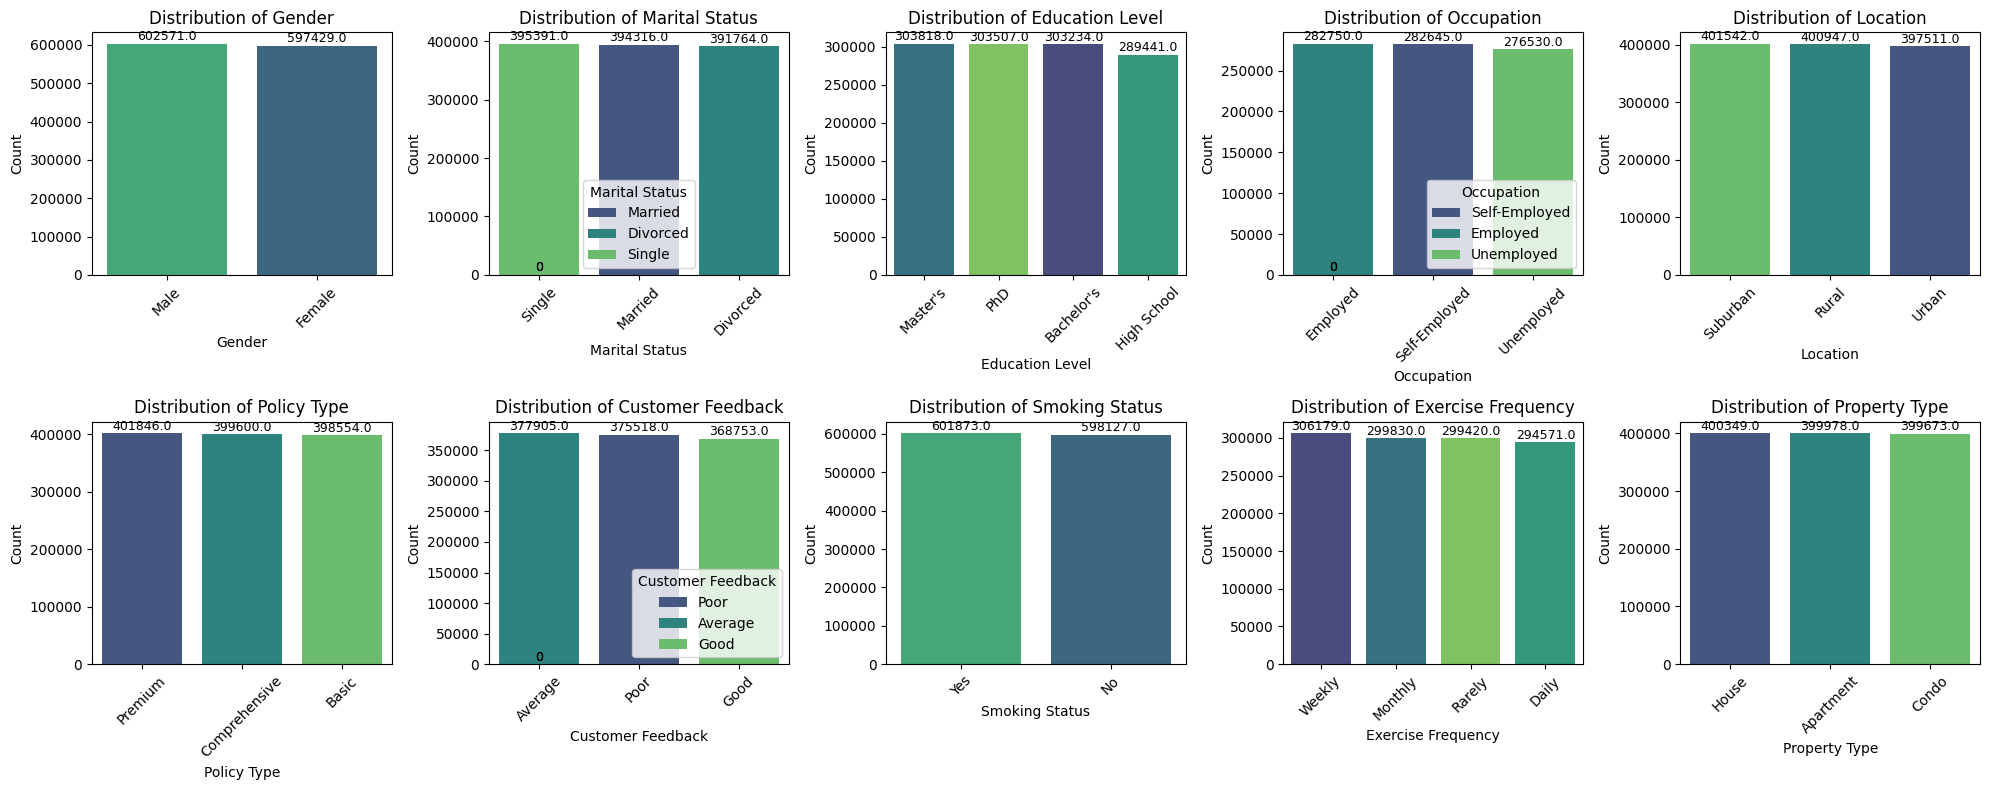

In [14]:
# Get categorical columns (v2)
cat_columns = insurance_train_data.select_dtypes(include=["object"]).columns

# Exclude 'Policy Start Date' from the list of categorical columns
cat_columns = [col for col in cat_columns if col != 'Policy Start Date']

# Define the grid size (5 columns)
num_cols = 5
num_rows = (len(cat_columns) // num_cols) + (len(cat_columns) % num_cols > 0)

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 4 * num_rows))  # Adjust height based on the number of rows

# Loop through categorical columns and plot their distributions
for i, col in enumerate(cat_columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Position plot in 4x5 grid
    
    ax = sns.countplot(x=insurance_train_data[col], order=insurance_train_data[col].value_counts().index, 
                       hue=insurance_train_data[col], palette="viridis") # ,legend=False
    
    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=9, color='black', 
                    xytext=(0, 5), textcoords='offset points')
    
    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    
    # Title and labels
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
# Display category counts instead of plotting
for col in cat_columns:
    print(f"\n{col} Distribution:\n", insurance_train_data[col].value_counts())


Gender Distribution:
 Gender
Male      602571
Female    597429
Name: count, dtype: int64

Marital Status Distribution:
 Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Education Level Distribution:
 Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Occupation Distribution:
 Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Location Distribution:
 Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Policy Type Distribution:
 Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Customer Feedback Distribution:
 Customer Feedback
Average    377905
Poor       375518
Good       368753
Name: count, dtype: int64

Smoking Status Distribution:
 Smoking Status
Yes    601873
No     598127
Name: count, dtype: in

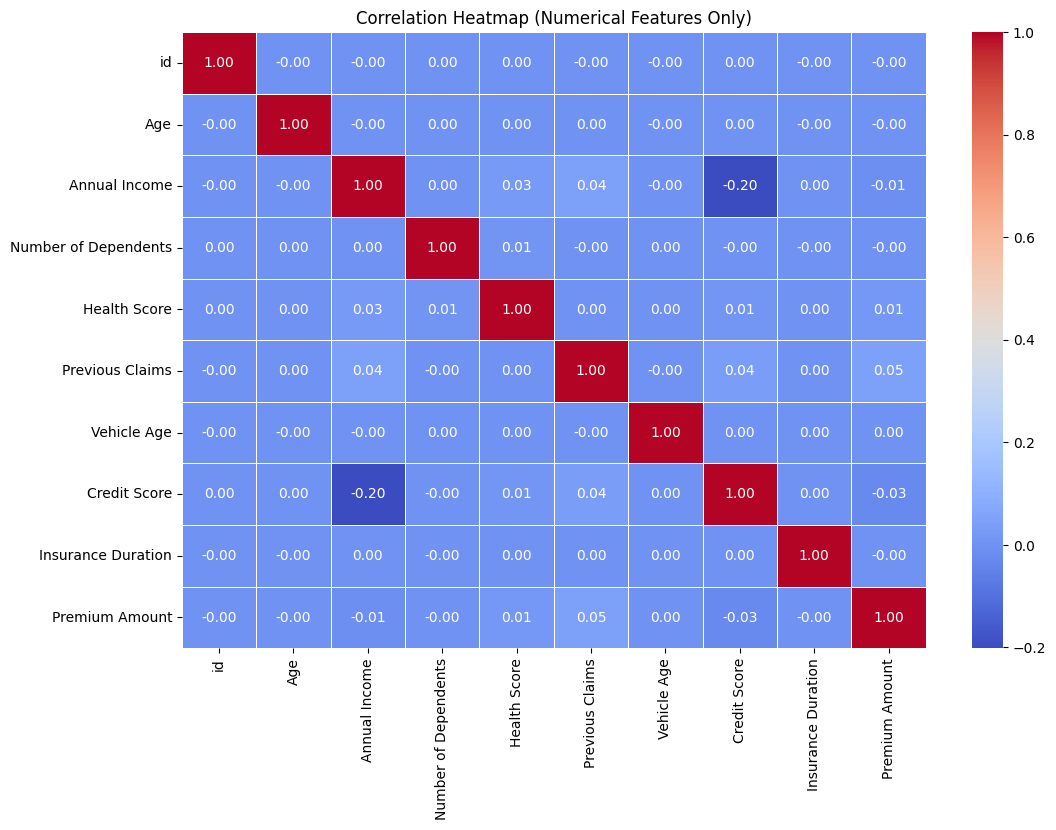

In [16]:
# Select only numerical columns
num_features = insurance_train_data.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = num_features.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features Only)")
plt.show()

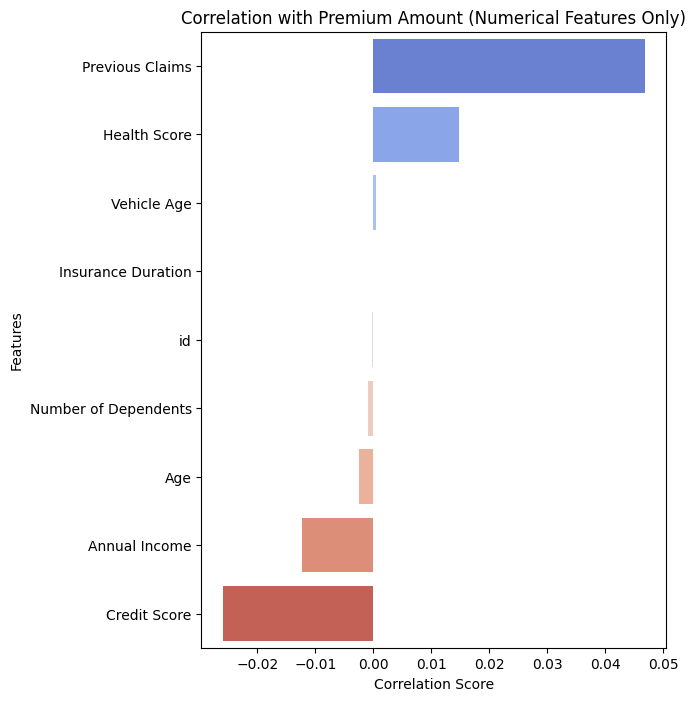

In [17]:
# v2
# Get correlation with target variable "Premium Amount"
corr_with_target = corr_matrix["Premium Amount"].drop("Premium Amount")

# Visualizing Correlation with Target Variable
plt.figure(figsize=(6, 8))
sns.barplot(
    y=corr_with_target.sort_values(ascending=False).index,
    x=corr_with_target.sort_values(ascending=False).values,
    hue=corr_with_target.sort_values(ascending=False).index,  # Assign y to hue
    palette="coolwarm"
    # legend=False  # Hide legend since hue is only for coloring
)
plt.title("Correlation with Premium Amount (Numerical Features Only)")
plt.xlabel("Correlation Score")
plt.ylabel("Features")
plt.show()

## Data Preprocessing

#### Handling Missing Values

In [18]:
# 1. Id - Not needed for analysis
# if "id" in insurance_train_data.columns:
#     insurance_train_data.drop(columns=["id"], inplace=True)
#     print("Column 'id' dropped successfully.")
# else:
#     print("Column 'id' does not exist in the dataset.")
# DO NOT DROP, needed for Submission File!

In [19]:
# 2. Age - Okay to drop Age if Small percentage of missing values, otherwise impute
if missing_info.loc["Age"]["Missing Percentage"] < 5:
    insurance_train_data.dropna(subset=["Age"], inplace=True)
else:
    insurance_train_data["Age"].fillna(insurance_train_data["Age"].median(), inplace=True)

In [20]:
# 3. Gender - Tag missing values as Unknown
insurance_train_data.loc[:, "Gender"] = insurance_train_data["Gender"].fillna("Unknown")

In [21]:
# 4. Annual Income - Okay to drop Age if Small percentage of missing values, otherwise impute
if missing_info.loc["Annual Income"]["Missing Percentage"] < 5:
    insurance_train_data.dropna(subset=["Annual Income"], inplace=True)
else:
    insurance_train_data["Annual Income"].fillna(insurance_train_data["Annual Income"].median(), inplace=True)

In [22]:
# 5. Marital Status - Tag missing values as Single
# insurance_train_data["Marital Status"].replace({"Unknown": "Single"}, inplace=True)
insurance_train_data.loc[:, "Marital Status"] = insurance_train_data["Marital Status"].fillna("Single")

In [23]:
# 6. Number of Dependents - Default missing values to 0 dependents
insurance_train_data.loc[:, "Number of Dependents"] = insurance_train_data["Number of Dependents"].fillna(0)

In [24]:
# 7. Education Level - No missing values now, but in the future, default it to Unknown
insurance_train_data.loc[:, "Education Level"] = insurance_train_data["Education Level"].fillna("Unknown")

In [25]:
# 8. Occupation - Default to Unemployed
insurance_train_data.loc[:, "Occupation"] = insurance_train_data["Occupation"].fillna("Unemployed")

In [26]:
# 9. Health Score - Default to 0
insurance_train_data.loc[:, "Health Score"] = insurance_train_data["Health Score"].fillna(0)

In [27]:
# 10. Location - No missing values now, but in the future, default it to Unknown
insurance_train_data.loc[:, "Location"] = insurance_train_data["Location"].fillna("Unknown")

In [28]:
# 11. Policy Type - No missing values now, but in the future, default it to Basic
insurance_train_data.loc[:, "Policy Type"] = insurance_train_data["Policy Type"].fillna("Basic")

In [29]:
# 12. Previous Claims - Default to 0, no claim
insurance_train_data.loc[:, "Previous Claims"] = insurance_train_data["Previous Claims"].fillna(0)

In [30]:
# 13. Vehicle Age - Default to 0, no vehicle declared
insurance_train_data.loc[:, "Vehicle Age"] = insurance_train_data["Vehicle Age"].fillna(0)

In [31]:
# 14. Credit Score - Default to 0, possibly newcomers
insurance_train_data.loc[:, "Credit Score"] = insurance_train_data["Credit Score"].fillna(0)

In [32]:
# 15. Insurance Duration - Default to 0, new policy holders
insurance_train_data.loc[:, "Insurance Duration"] = insurance_train_data["Insurance Duration"].fillna(0)

In [33]:
# 16. Policy Start Date - No missing values now, but dropped if not provided
insurance_train_data.dropna(subset=["Policy Start Date"], inplace=True)

In [34]:
# 17. Customer Feedback - Default to Not Provided
insurance_train_data.loc[:, "Customer Feedback"] = insurance_train_data["Customer Feedback"].fillna("Not Provided")

In [35]:
# 18. Smoking Status - No missing values now, but in the future, default to No
insurance_train_data.loc[:, "Smoking Status"] = insurance_train_data["Smoking Status"].fillna("No")

In [36]:
# 19. Exercise Frequency - No missing values now, but in the future, default to Not Provided
insurance_train_data.loc[:, "Exercise Frequency"] = insurance_train_data["Exercise Frequency"].fillna("Not Provided")

In [37]:
# 20. Property Type - No missing values now, but in the future, default to Not Provided
insurance_train_data.loc[:, "Property Type"] = insurance_train_data["Property Type"].fillna("Not Provided")

In [38]:
# 21. Premium Amount - No missing values now, but in the future, drop if not provided
insurance_train_data.dropna(subset=["Premium Amount"], inplace=True)

#### Feature Engineering & Transformation

In [39]:
# 1. Id - No further action

In [40]:
# 2. Age - Binning
# Define the bins for age groups relevant for health insurance coverage
bins = [0, 5, 18, 25, 35, 45, 55, 65, float('inf')]  # Age bin edges
labels = ["High Risk (0-5) (Infants)", "Moderate Risk (6-18) (Children & Adolescents)", "Low Risk (19-25) (Young Adults)", 
          "Moderate-Low Risk (26-35) (Early Adulthood)", "Moderate Risk (36-45) (Middle Adulthood)", 
          "High Risk (46-55) (Mature Adults)", "Very High Risk (56-65) (Pre-Retirement)", "Very High Risk (65+) (Seniors)"]

# Create a new column with binned age groups
# right=True includes the rightmost edge
insurance_train_data["Age_Bin"] = pd.cut(insurance_train_data["Age"], bins=bins, labels=labels, right=True)
# Check the result
print(insurance_train_data['Age_Bin'].value_counts())

# Define the mapping of age bin labels to numeric values
age_bin_mapping = {
    "High Risk (0-5) (Infants)": 1,
    "Moderate Risk (6-18) (Children & Adolescents)": 2,
    "Low Risk (19-25) (Young Adults)": 3,
    "Moderate-Low Risk (26-35) (Early Adulthood)": 4,
    "Moderate Risk (36-45) (Middle Adulthood)": 5,
    "High Risk (46-55) (Mature Adults)": 6,
    "Very High Risk (56-65) (Pre-Retirement)": 7,
    "Very High Risk (65+) (Seniors)": 8
}
# Apply the mapping to the Age Bin column to convert it to numeric values
insurance_train_data["Age_Bin Numeric"] = insurance_train_data["Age_Bin"].map(age_bin_mapping)
# Convert the binned column to integer codes
insurance_train_data["Age_Bin Numeric"] = insurance_train_data["Age_Bin Numeric"].cat.codes
# Check the result
print(insurance_train_data[['Age', 'Age_Bin', 'Age_Bin Numeric']].head())

Age_Bin
High Risk (46-55) (Mature Adults)                243558
Moderate Risk (36-45) (Middle Adulthood)         242815
Moderate-Low Risk (26-35) (Early Adulthood)      241035
Very High Risk (56-65) (Pre-Retirement)          220555
Low Risk (19-25) (Young Adults)                  165605
Moderate Risk (6-18) (Children & Adolescents)     23518
High Risk (0-5) (Infants)                             0
Very High Risk (65+) (Seniors)                        0
Name: count, dtype: int64
    Age                                   Age_Bin  Age_Bin Numeric
0  19.0           Low Risk (19-25) (Young Adults)                2
1  39.0  Moderate Risk (36-45) (Middle Adulthood)                4
2  23.0           Low Risk (19-25) (Young Adults)                2
3  21.0           Low Risk (19-25) (Young Adults)                2
4  21.0           Low Risk (19-25) (Young Adults)                2


In [41]:
# 3. Gender - One-Hot Encoding
# Check if the "Gender" column still exists in the DataFrame
if "Gender" in insurance_train_data.columns:
    # Perform one-hot encoding for "Gender" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Gender"], drop_first=False)
    print("Gender column has been one-hot encoded.")
else:
    print("Gender column has already been one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Gender_Male' in insurance_train_data.columns:
    insurance_train_data['Gender_Male'] = insurance_train_data['Gender_Male'].astype(int)
if 'Gender_Female' in insurance_train_data.columns:
    insurance_train_data['Gender_Female'] = insurance_train_data['Gender_Female'].astype(int)
if 'Gender_Unknown' in insurance_train_data.columns:
    insurance_train_data['Gender_Unknown'] = insurance_train_data['Gender_Unknown'].astype(int)

Gender column has been one-hot encoded.


In [42]:
# 4. Annual Income - Binning
# No need to perform Box-Cox Transformation as Binning was applied
# Define the income bins and labels
income_bins = [0, 25000, 50000, 100000, 150000, float('inf')]  # Define bin edges
income_labels = ["Low Income (0-25k)", "Lower-Middle Income (25k-50k)", 
                 "Middle Income (50k-100k)", "Upper-Middle Income (100k-150k)", 
                 "High Income (150k+)"]

# Create a new column for binned income groups
# right=True includes the rightmost edge
insurance_train_data["Income_Bin"] = pd.cut(insurance_train_data["Annual Income"], bins=income_bins, labels=income_labels, right=False)
# Check the result
print(insurance_train_data['Income_Bin'].value_counts())

# Define the mapping of income bin labels to numeric values
income_bin_mapping = {
    "Low Income (0-25k)": 1,
    "Lower-Middle Income (25k-50k)": 2,
    "Middle Income (50k-100k)": 3,
    "Upper-Middle Income (100k-150k)": 4,
    "High Income (150k+)": 5
}
# Apply the mapping to the Income Bin column to convert it to numeric values
insurance_train_data["Income_Bin Numeric"] = insurance_train_data["Income_Bin"].map(income_bin_mapping)
# Convert the binned column to integer codes
insurance_train_data["Income_Bin Numeric"] = insurance_train_data["Income_Bin Numeric"].cat.codes
# Check the result
print(insurance_train_data[['Annual Income', 'Income_Bin', 'Income_Bin Numeric']].head())

Income_Bin
Low Income (0-25k)                 591399
Lower-Middle Income (25k-50k)      309977
Middle Income (50k-100k)           170188
Upper-Middle Income (100k-150k)     65522
High Income (150k+)                     0
Name: count, dtype: int64
   Annual Income                       Income_Bin  Income_Bin Numeric
0        10049.0               Low Income (0-25k)                   0
1        31678.0    Lower-Middle Income (25k-50k)                   1
2        25602.0    Lower-Middle Income (25k-50k)                   1
3       141855.0  Upper-Middle Income (100k-150k)                   3
4        39651.0    Lower-Middle Income (25k-50k)                   1


In [43]:
# 5. Marital Status - One-Hot Encoding
# Check if the "Marital Status" column still exists in the DataFrame
if "Marital Status" in insurance_train_data.columns:
    # Perform one-hot encoding for "Marital Status" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Marital Status"], drop_first=False)
    print("Marital Status column has been one-hot encoded.")
else:
    print("Marital Status column has already been one-hot encoded.")

Marital Status column has been one-hot encoded.


In [44]:
# 6. Number of Dependents - No action required.

In [45]:
# 7. Education Level - Label Encoding because of sequence
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Define the desired order for the 'Education Level' categories
desired_order = ["Unknown","High School", "Bachelor's", "Master's", "PhD"]

# Ensure the encoder fits based on the custom order
label_encoder.classes_ = np.array(desired_order)

# Apply the label encoder
insurance_train_data['Education Level_Encoded'] = label_encoder.transform(insurance_train_data['Education Level'])
# Check the result
print(insurance_train_data['Education Level_Encoded'].value_counts())

Education Level_Encoded
3    287723
4    287653
2    287337
1    274373
Name: count, dtype: int64


In [46]:
# 8. Occupation - One-Hot Encoding
# Check if the "Occupation" column still exists in the DataFrame
if "Occupation" in insurance_train_data.columns:
    # Merge Employed and Self-Employed into 'Employed/Self-Employed', and keep 'Unemployed' as it is
    insurance_train_data['Occupation'] = insurance_train_data['Occupation'].replace({
        'Employed': 'Employed/Self-Employed', 
        'Self-Employed': 'Employed/Self-Employed'
    })
    # One-hot encode the 'Occupation' column
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=['Occupation'])
    print("Occupation column has been merged and one-hot encoded.")
else:
    print("Occupation column has already been merged and one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Occupation_Employed/Self-Employed' in insurance_train_data.columns:
    insurance_train_data['Occupation_Employed/Self-Employed'] = insurance_train_data['Occupation_Employed/Self-Employed'].astype(int)
if 'Occupation_Unemployed' in insurance_train_data.columns:
    insurance_train_data['Occupation_Unemployed'] = insurance_train_data['Occupation_Unemployed'].astype(int)

Occupation column has been merged and one-hot encoded.


In [47]:
# 9. Health Score - No action required.

In [48]:
# 10. Location - One-Hot Encoding
# Check if the "Location" column still exists in the DataFrame
if "Location" in insurance_train_data.columns:
    # Perform one-hot encoding for "Location" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Location"], drop_first=False)
    print("Location column has been one-hot encoded.")
else:
    print("Location column has already been one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Location_Suburban' in insurance_train_data.columns:
    insurance_train_data['Location_Suburban'] = insurance_train_data['Location_Suburban'].astype(int)
if 'Location_Rural' in insurance_train_data.columns:
    insurance_train_data['Location_Rural'] = insurance_train_data['Location_Rural'].astype(int)
if 'Location_Urban' in insurance_train_data.columns:
    insurance_train_data['Location_Urban'] = insurance_train_data['Location_Urban'].astype(int)
if 'Location_Unknown' in insurance_train_data.columns:
    insurance_train_data['Location_Unknown'] = insurance_train_data['Location_Unknown'].astype(int)

Location column has been one-hot encoded.


In [49]:
# 11. Policy Type - One-Hot Encoding
# Check if the "Policy Type" column still exists in the DataFrame
if "Policy Type" in insurance_train_data.columns:
    # Perform one-hot encoding for "Policy Type" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Policy Type"], drop_first=False)
    print("Policy Type column has been one-hot encoded.")
else:
    print("Policy Type column has already been one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Policy Type_Basic' in insurance_train_data.columns:
    insurance_train_data['Policy Type_Basic'] = insurance_train_data['Policy Type_Basic'].astype(int)
if 'Policy Type_Comprehensive' in insurance_train_data.columns:
    insurance_train_data['Policy Type_Comprehensive'] = insurance_train_data['Policy Type_Comprehensive'].astype(int)
if 'Policy Type_Premium' in insurance_train_data.columns:
    insurance_train_data['Policy Type_Premium'] = insurance_train_data['Policy Type_Premium'].astype(int)

Policy Type column has been one-hot encoded.


In [50]:
# 12. Previous Claims - Apply Box-Cox Transformation
# Select skewed numerical columns
skewed_features = ['Previous Claims']

# Ensure all values are positive (Box-Cox requires positive numbers)
insurance_train_data[skewed_features] = insurance_train_data[skewed_features].apply(lambda x: x + 1 if (x <= 0).any() else x)

# Apply Box-Cox transformation
for col in skewed_features:
    insurance_train_data[col], _ = boxcox(insurance_train_data[col])
# Check the result
print(insurance_train_data['Previous Claims'].value_counts())

Previous Claims
0.000000    635423
0.468220    285580
0.605892    158099
0.669637     45764
0.705798      9967
0.728860      1904
0.744740       285
0.756282        55
0.765017         8
0.771838         1
Name: count, dtype: int64


In [51]:
# 13. Vehicle Age - No action required.

In [52]:
# 14. Credit Score - No action required.

In [53]:
# 15. Insurance Duration - No action required.

In [54]:
# 16. Policy Start Date - Extract Temporal Patters.
# Convert the 'Policy Start Date' to datetime format
insurance_train_data['Policy Start Date'] = pd.to_datetime(insurance_train_data['Policy Start Date'], errors='coerce')

# Extract year from the date
insurance_train_data['Policy Start Year'] = insurance_train_data['Policy Start Date'].dt.year

# Extract the month from the date
insurance_train_data['Policy Start Month'] = insurance_train_data['Policy Start Date'].dt.month

# Extract the difference in years from the current date
insurance_train_data['Years Since Start'] = (pd.to_datetime('today') - insurance_train_data['Policy Start Date']).dt.days / 365

# Drop the original 'Policy Start Date' if no longer needed
insurance_train_data.drop(columns=["Policy Start Date"], inplace=True)

In [55]:
# 17. Customer Feedback - One-Hot Encoding
# Check if the "Customer Feedback" column still exists in the DataFrame
if "Customer Feedback" in insurance_train_data.columns:
    # Perform one-hot encoding for "Customer Feedback" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Customer Feedback"], drop_first=False)
    print("Customer Feedback column has been one-hot encoded.")
else:
    print("Customer Feedback column has already been one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Customer Feedback_Poor' in insurance_train_data.columns:
    insurance_train_data['Customer Feedback_Poor'] = insurance_train_data['Customer Feedback_Poor'].astype(int)
if 'Customer Feedback_Average' in insurance_train_data.columns:
    insurance_train_data['Customer Feedback_Average'] = insurance_train_data['Customer Feedback_Average'].astype(int)
if 'Customer Feedback_Good' in insurance_train_data.columns:
    insurance_train_data['Customer Feedback_Good'] = insurance_train_data['Customer Feedback_Good'].astype(int)
if 'Customer Feedback_Not Provided' in insurance_train_data.columns:
    insurance_train_data['Customer Feedback_Not Provided'] = insurance_train_data['Customer Feedback_Not Provided'].astype(int)

Customer Feedback column has been one-hot encoded.


In [56]:
# 18. Smoking Status - No = 0; Yes = 1
# Map "No" to 0 and "Yes" to 1 in the Smoking Status column
insurance_train_data['Smoking Status'] = insurance_train_data['Smoking Status'].map({'No': 0, 'Yes': 1})
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Smoking Status' column to convert "No" and "Yes" to 0 and 1
insurance_train_data['Smoking Status'] = label_encoder.fit_transform(insurance_train_data['Smoking Status'])
# Check the result
print(insurance_train_data['Smoking Status'].value_counts())

Smoking Status
1    570424
0    566662
Name: count, dtype: int64


In [57]:
# 19. Exercise Frequency - Label Encoding based on frequency
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Define the desired order for the 'Exercise Frequency' categories
desired_order = ["Not Provided","Rarely", "Daily", "Weekly", "Monthly"]

# Ensure the encoder fits based on the custom order
label_encoder.classes_ = np.array(desired_order)

# Apply the label encoder
insurance_train_data['Exercise Frequency Encoded'] = label_encoder.transform(insurance_train_data['Exercise Frequency'])
# Check the result
print(insurance_train_data['Exercise Frequency Encoded'].value_counts())

Exercise Frequency Encoded
3    290106
4    284292
1    283880
2    278808
Name: count, dtype: int64


In [58]:
# 20. Property Type - One-Hot Encoding
# Check if the "Property Type" column still exists in the DataFrame
if "Property Type" in insurance_train_data.columns:
    # Perform one-hot encoding for "Customer Feedback" if it hasn't been done already
    insurance_train_data = pd.get_dummies(insurance_train_data, columns=["Property Type"], drop_first=False)
    print("Property Type column has been one-hot encoded.")
else:
    print("Property Type column has already been one-hot encoded.")

# Convert the boolean True/False values to 1/0
if 'Property Type_House' in insurance_train_data.columns:
    insurance_train_data['Property Type_House'] = insurance_train_data['Property Type_House'].astype(int)
if 'Property Type_Apartment' in insurance_train_data.columns:
    insurance_train_data['Property Type_Apartment'] = insurance_train_data['Property Type_Apartment'].astype(int)
if 'Property Type_Condo' in insurance_train_data.columns:
    insurance_train_data['Property Type_Condo'] = insurance_train_data['Property Type_Condo'].astype(int)
if 'Property Type_Unknown' in insurance_train_data.columns:
    insurance_train_data['Property Type_Unknown'] = insurance_train_data['Property Type_Unknown'].astype(int)

Property Type column has been one-hot encoded.


In [59]:
# Check ideal Lambda value for Premium Amount
premium_amount_data = insurance_train_data['Premium Amount']

# Apply Box-Cox transformation and calculate the optimal lambda
transformed_data, optimal_lambda = boxcox(premium_amount_data)

# Plot the transformed data for a range of lambdas
lambda_range = np.linspace(-2, 2, 100)  # Lambda range from -2 to 2
transformed_range = np.array([boxcox(premium_amount_data, lmbda=lmbda)[0] for lmbda in lambda_range])

# Output optimal lambda and the range used for transformations
print(f"Optimal lambda: {optimal_lambda}")
print(f"Lambda range: {lambda_range[0]} to {lambda_range[-1]}")

Optimal lambda: 0.4061359533323342
Lambda range: -2.0 to 2.0


In [60]:
# 21. Premium Amount - Apply Box-Cox Transformation (to be reverted after modelling)
# Apply Box-Cox transformation with a hardcoded lambda value
lambda_value = 0.406 
insurance_train_data['Premium Amount'] = boxcox(insurance_train_data['Premium Amount'] + 1, lmbda=lambda_value)

# Check the result
print(insurance_train_data['Premium Amount'].value_counts())
print(f"Lambda value for 'Premium Amount': {lambda_value}")

Premium Amount
6.782930     4022
6.636867     3662
6.014977     3628
6.487290     3308
7.202073     3240
             ... 
75.694947       1
73.805532       1
75.350581       1
72.524887       1
75.273752       1
Name: count, Length: 4787, dtype: int64
Lambda value for 'Premium Amount': 0.406


#### Handling Outliers

In [61]:
# Numerical features that will not require outlier handling:
# 1. Age underwent binning
# 2. Annual Income underwent binning

In [62]:
# Number of Dependents - Cap to a maximum of 10
insurance_train_data['Number of Dependents'] = np.where(
    insurance_train_data['Number of Dependents'] > 10, 10,
    insurance_train_data['Number of Dependents']
)
print(insurance_train_data['Number of Dependents'].describe())

count    1.137086e+06
mean     1.826128e+00
std      1.469595e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      4.000000e+00
Name: Number of Dependents, dtype: float64


In [63]:
# Health Score - Drop extreme values
# Calculate the first and third quartile (Q1 and Q3)
Q1 = insurance_train_data['Health Score'].quantile(0.25)
Q3 = insurance_train_data['Health Score'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows where 'Health Score' is an outlier
insurance_train_data = insurance_train_data[(insurance_train_data['Health Score'] >= lower_bound) & 
                                            (insurance_train_data['Health Score'] <= upper_bound)]
print(insurance_train_data['Health Score'].describe())

count    1.137086e+06
mean     2.398984e+01
std      1.330780e+01
min      0.000000e+00
25%      1.401079e+01
50%      2.326426e+01
75%      3.373437e+01
max      5.897591e+01
Name: Health Score, dtype: float64


In [64]:
# Previous Claims - Undergo binning
# Define the bins and labels for Previous Claims based on the stats
bins = [-1, 0, 2, 5, 9, float('inf')]  # Define the bin edges
labels = ['No Claims', 'Few Claims (1-2)', 'Moderate Claims (3-5)', 'High Claims (6-9)', 'Extreme Claims (9+)']  # Define the bin labels
# Apply binning using pd.cut
insurance_train_data['Previous Claims_Bin'] = pd.cut(insurance_train_data['Previous Claims'], bins=bins, labels=labels)
# Check the result
print(insurance_train_data['Previous Claims_Bin'].value_counts())

# Define the mapping of age bin labels to numeric values
previous_claims_bin_mapping = {
    "No Claims": 1,
    "Few Claims (1-2)": 2,
    "Moderate Claims (3-5)": 3,
    "High Claims (6-9)": 4,
    "Extreme Claims (9+)": 5
}
# Apply the mapping to the Previous Claims Bin column to convert it to numeric values
insurance_train_data["Previous Claims_Bin Numeric"] = insurance_train_data["Previous Claims_Bin"].map(previous_claims_bin_mapping)
# Convert the binned column to integer codes
insurance_train_data["Previous Claims_Bin Numeric"] = insurance_train_data["Previous Claims_Bin Numeric"].cat.codes
# Check the result
print(insurance_train_data[['Previous Claims', 'Previous Claims_Bin', 'Previous Claims_Bin Numeric']].head())

Previous Claims_Bin
No Claims                635423
Few Claims (1-2)         501663
Moderate Claims (3-5)         0
High Claims (6-9)             0
Extreme Claims (9+)           0
Name: count, dtype: int64
   Previous Claims Previous Claims_Bin  Previous Claims_Bin Numeric
0         0.605892    Few Claims (1-2)                            1
1         0.468220    Few Claims (1-2)                            1
2         0.468220    Few Claims (1-2)                            1
3         0.468220    Few Claims (1-2)                            1
4         0.000000           No Claims                            0


In [65]:
# Vehicle Age - Winsorization/Cap to a maximum of 15
print("Before:")
print(insurance_train_data['Vehicle Age'].describe())
insurance_train_data['Vehicle Age'] = np.where(
    insurance_train_data['Vehicle Age'] > 15, 15,
    insurance_train_data['Vehicle Age']
)
print("After:")
print(insurance_train_data['Vehicle Age'].describe())

Before:
count    1.137086e+06
mean     9.571087e+00
std      5.776555e+00
min      0.000000e+00
25%      5.000000e+00
50%      1.000000e+01
75%      1.500000e+01
max      1.900000e+01
Name: Vehicle Age, dtype: float64
After:
count    1.137086e+06
mean     9.061272e+00
std      5.103658e+00
min      0.000000e+00
25%      5.000000e+00
50%      1.000000e+01
75%      1.500000e+01
max      1.500000e+01
Name: Vehicle Age, dtype: float64


In [66]:
# Credit Score - Drop extreme values
# Calculate the first and third quartile (Q1 and Q3)
Q1 = insurance_train_data['Credit Score'].quantile(0.25)
Q3 = insurance_train_data['Credit Score'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows where 'Credit Score' is an outlier
insurance_train_data = insurance_train_data[(insurance_train_data['Credit Score'] >= lower_bound) & 
                                            (insurance_train_data['Credit Score'] <= upper_bound)]
print(insurance_train_data['Credit Score'].describe())

count    1.004659e+06
mean     5.961158e+02
std      1.488250e+02
min      3.000000e+02
25%      4.730000e+02
50%      6.000000e+02
75%      7.230000e+02
max      8.490000e+02
Name: Credit Score, dtype: float64


In [67]:
# Insurance Duration - Undergo binning for data flexibility
# Define the bins and labels for Insurance Duration
bins = [-1, 1, 3, 8, float('inf')]  # Define the bin edges
labels = ['New Clients (0-1)', 'Repeat Clients (2-3)', 'Established Clients (4-8)', 'Very Loyal Clients (9+)']  # Define the bin labels
# Apply binning using pd.cut
insurance_train_data['Insurance Duration_Bin'] = pd.cut(insurance_train_data['Insurance Duration'], bins=bins, labels=labels)
# Check the result
print(insurance_train_data['Insurance Duration_Bin'].value_counts())

# Define the mapping of age bin labels to numeric values
insurance_duration_bin_mapping = {
    "New Clients (0-1)": 1,
    "Repeat Clients (2-3)": 2,
    "Established Clients (4-8)": 3,
    "Very Loyal Clients (9+)": 4
}
# Apply the mapping to the Insurance Duration Bin column to convert it to numeric values
insurance_train_data["Insurance Duration_Bin Numeric"] = insurance_train_data["Insurance Duration_Bin"].map(insurance_duration_bin_mapping)
# Convert the binned column to integer codes
insurance_train_data["Insurance Duration_Bin Numeric"] = insurance_train_data["Insurance Duration_Bin Numeric"].cat.codes
# Check the result
print(insurance_train_data[['Insurance Duration', 'Insurance Duration_Bin', 'Insurance Duration_Bin Numeric']].head())

Insurance Duration_Bin
Established Clients (4-8)    556463
Repeat Clients (2-3)         220049
Very Loyal Clients (9+)      115411
New Clients (0-1)            112736
Name: count, dtype: int64
   Insurance Duration     Insurance Duration_Bin  \
0                 5.0  Established Clients (4-8)   
1                 2.0       Repeat Clients (2-3)   
3                 1.0          New Clients (0-1)   
4                 4.0  Established Clients (4-8)   
5                 5.0  Established Clients (4-8)   

   Insurance Duration_Bin Numeric  
0                               2  
1                               1  
3                               0  
4                               2  
5                               2  


In [68]:
# Premium Amount - Drop extreme values
# Calculate the first and third quartile (Q1 and Q3)
Q1 = insurance_train_data['Premium Amount'].quantile(0.25)
Q3 = insurance_train_data['Premium Amount'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows where 'Premium Amount' is an outlier
insurance_train_data = insurance_train_data[(insurance_train_data['Premium Amount'] >= lower_bound) & 
                                            (insurance_train_data['Premium Amount'] <= upper_bound)]
print(insurance_train_data['Premium Amount'].describe())

count    1.000534e+06
mean     3.653932e+01
std      1.366349e+01
min      6.014977e+00
25%      2.890800e+01
50%      3.620339e+01
75%      4.550665e+01
max      7.084974e+01
Name: Premium Amount, dtype: float64


Statistical Analysis & Tests
-----

#### Checking Data Distributions

In [69]:
# Check sample values
insurance_train_data.head()

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,...,Customer Feedback_Not Provided,Customer Feedback_Poor,Exercise Frequency Encoded,Property Type_Apartment,Property Type_Condo,Property Type_House,Previous Claims_Bin,Previous Claims_Bin Numeric,Insurance Duration_Bin,Insurance Duration_Bin Numeric
0,0,19.0,10049.0,1.0,Bachelor's,22.598761,0.605892,15.0,372.0,5.0,...,0,1,3,0,0,1,Few Claims (1-2),1,Established Clients (4-8),2
1,1,39.0,31678.0,3.0,Master's,15.569731,0.468220,12.0,694.0,2.0,...,0,0,4,0,0,1,Few Claims (1-2),1,Repeat Clients (2-3),1
3,3,21.0,141855.0,2.0,Bachelor's,10.938144,0.468220,0.0,367.0,1.0,...,0,1,2,1,0,0,Few Claims (1-2),1,New Clients (0-1),0
4,4,21.0,39651.0,1.0,Bachelor's,20.376094,0.000000,8.0,598.0,4.0,...,0,1,3,0,0,1,No Claims,0,Established Clients (4-8),2
5,5,29.0,45963.0,1.0,Bachelor's,33.053198,0.605892,4.0,614.0,5.0,...,0,0,3,0,0,1,Few Claims (1-2),1,Established Clients (4-8),2


In [70]:
insurance_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000534 entries, 0 to 1199996
Data columns (total 46 columns):
 #   Column                             Non-Null Count    Dtype   
---  ------                             --------------    -----   
 0   id                                 1000534 non-null  int64   
 1   Age                                1000534 non-null  float64 
 2   Annual Income                      1000534 non-null  float64 
 3   Number of Dependents               1000534 non-null  float64 
 4   Education Level                    1000534 non-null  object  
 5   Health Score                       1000534 non-null  float64 
 6   Previous Claims                    1000534 non-null  float64 
 7   Vehicle Age                        1000534 non-null  float64 
 8   Credit Score                       1000534 non-null  float64 
 9   Insurance Duration                 1000534 non-null  float64 
 10  Smoking Status                     1000534 non-null  int64   
 11  Exercise Frequen

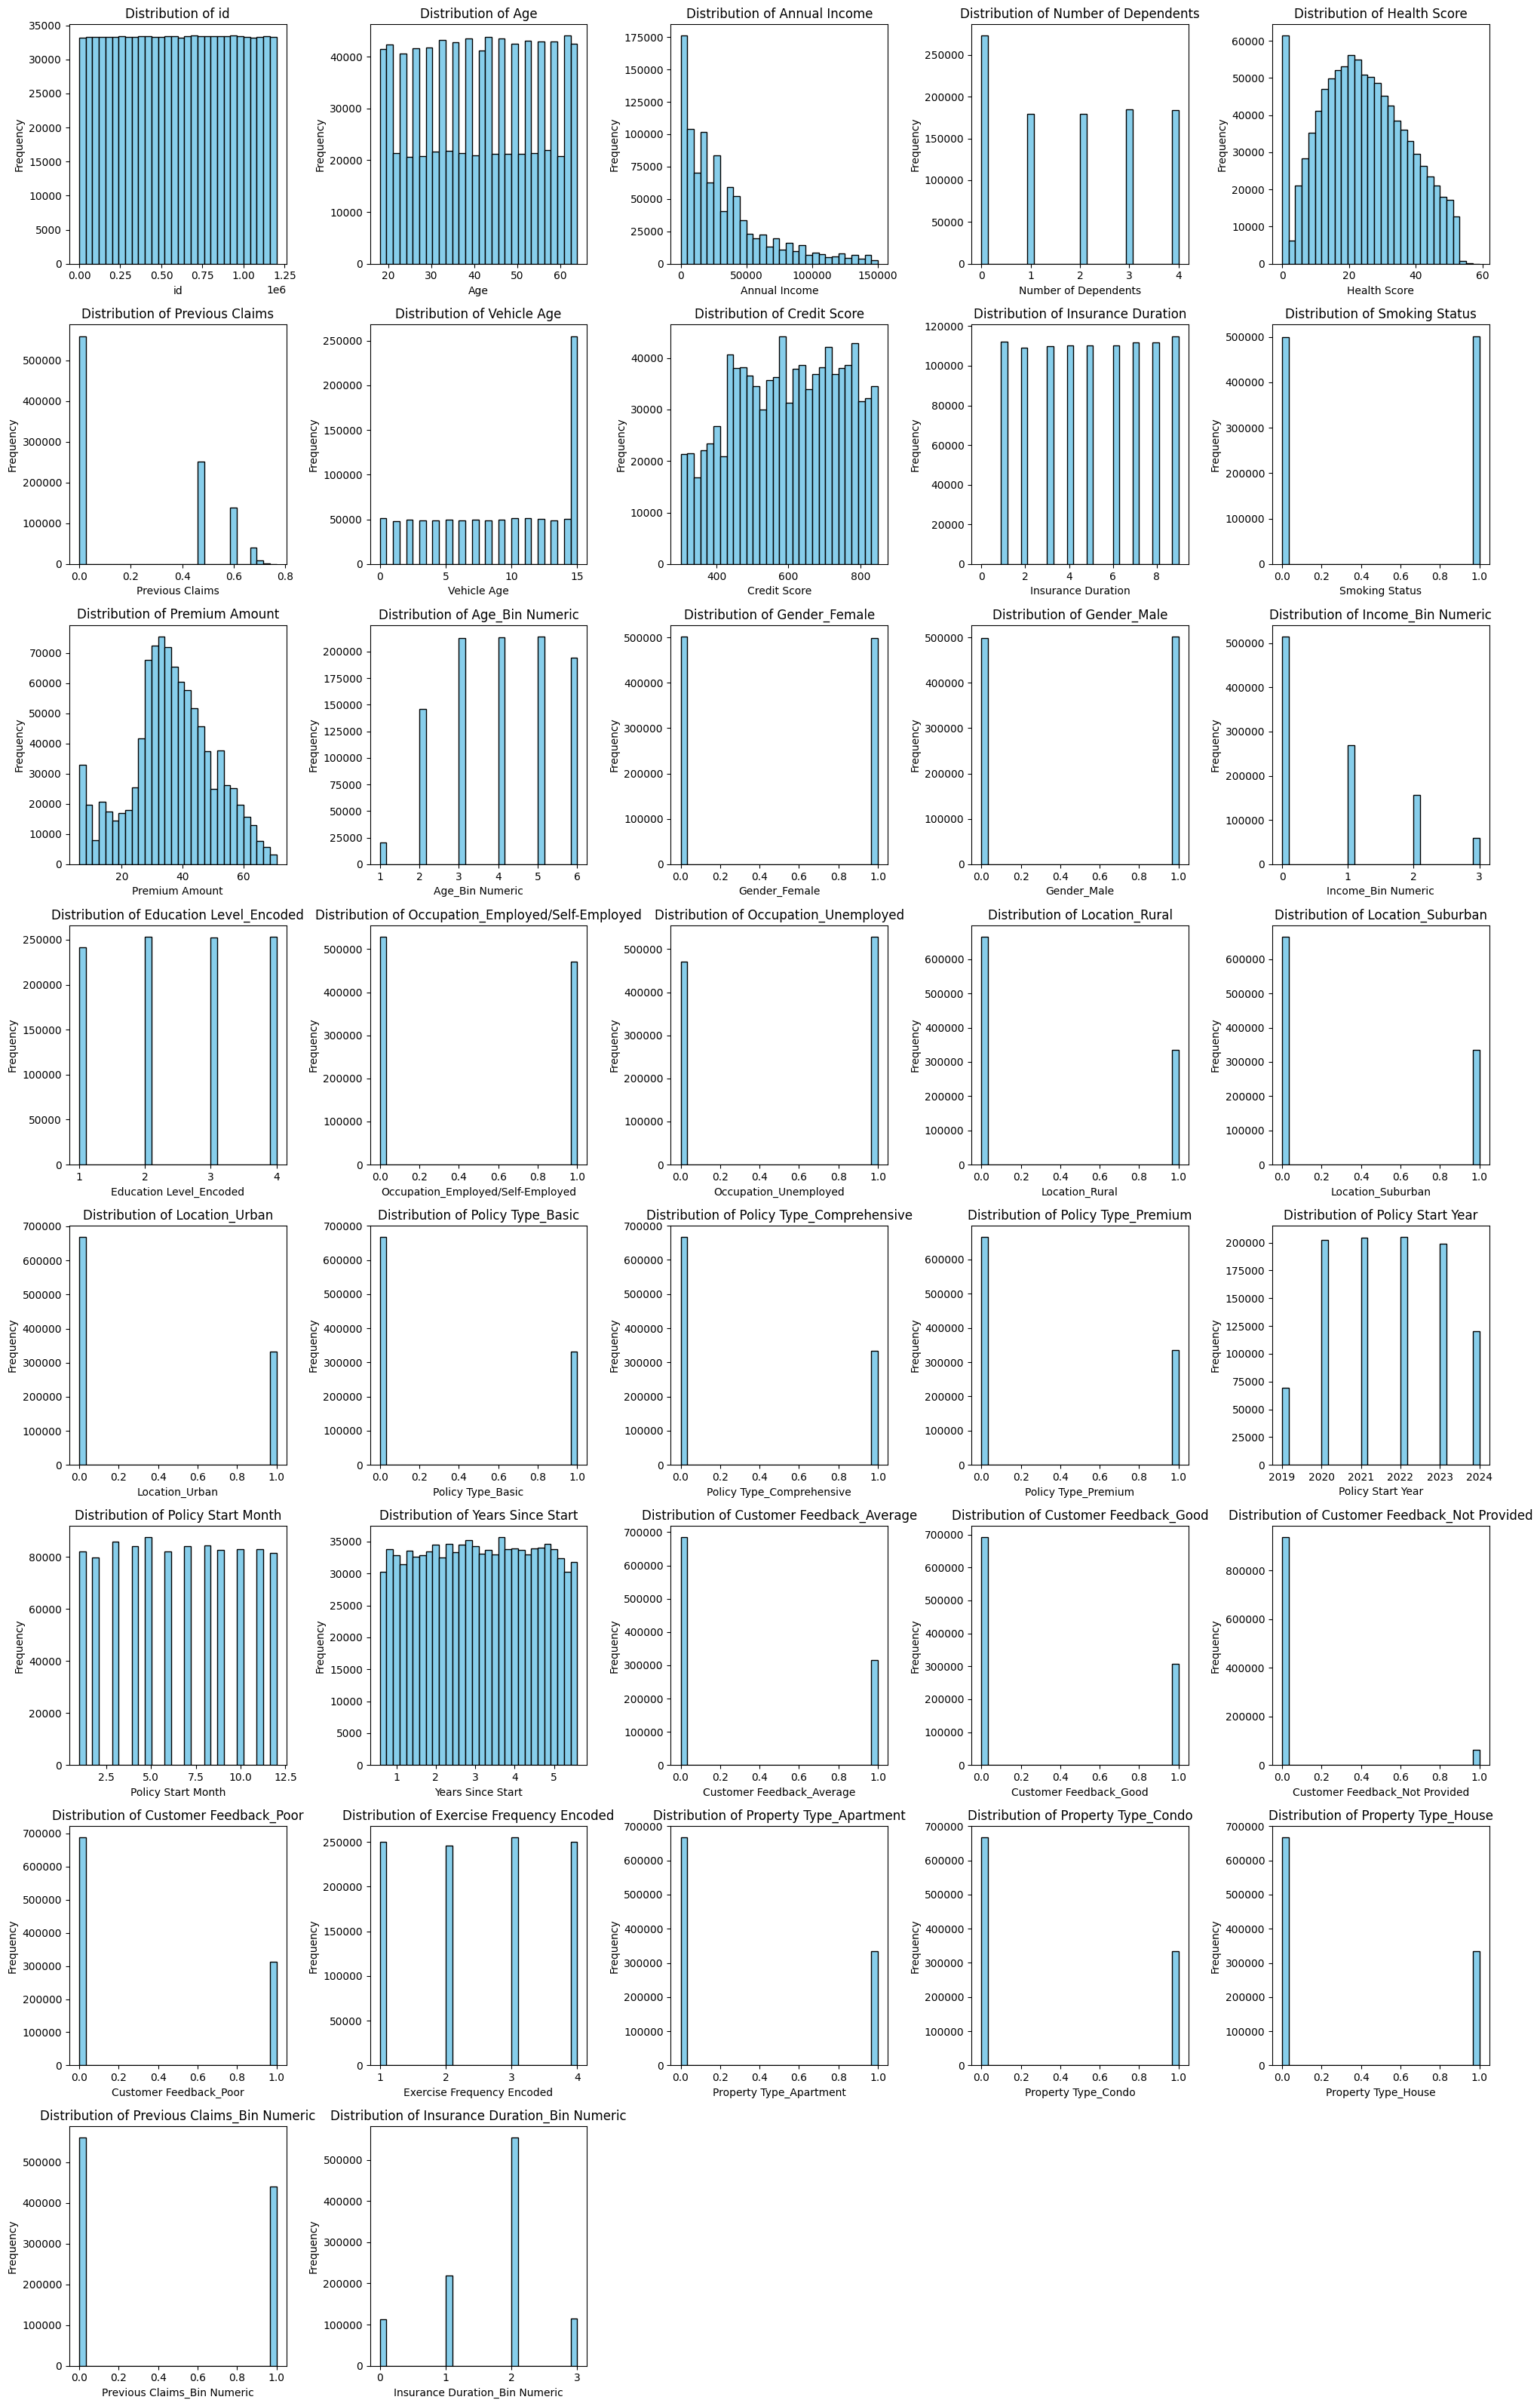

In [71]:
# Histogram (For Overall Distribution)
#insurance_train_data.hist(figsize=(12, 10), bins=30, edgecolor='black')
#plt.suptitle("Updated Feature Distributions", fontsize=16)
#plt.show()

# Check distribution of numerical features
# Get numerical columns
num_columns = insurance_train_data.select_dtypes(include=['number']).columns

# Define grid size (5 columns)
num_cols = 5
num_rows = (len(num_columns) // num_cols) + (len(num_columns) % num_cols > 0)

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 4 * num_rows))  # Adjust height based on the number of rows

# Loop through numerical columns and plot histograms
for i, col in enumerate(num_columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Position plot in a 4x5 grid
    plt.hist(insurance_train_data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [72]:
# Skewness Computation with Interpretation
# Select only numerical columns
numerical_columns = insurance_train_data.select_dtypes(include=['number'])

# Compute skewness
skew_values = numerical_columns.skew().sort_values(ascending=False)

# Create a DataFrame to store skewness values
skew_df = pd.DataFrame({'Skewness Value': skew_values})

# Apply interpretation directly
skew_df['Interpretation'] = ""

skew_df.loc[skew_df['Skewness Value'] == 0, 'Interpretation'] = "Norm Dist (γ₁ = 0)"
skew_df.loc[(skew_df['Skewness Value'] > -0.5) & (skew_df['Skewness Value'] < 0.5), 'Interpretation'] = "Min/No Skew (γ₁ = -0.5 to 0.5)"
skew_df.loc[skew_df['Skewness Value'] > 1, 'Interpretation'] = "Extreme Right-Skewed (γ₁ > 1)"
skew_df.loc[skew_df['Skewness Value'] < -1, 'Interpretation'] = "Extreme Left-Skewed (γ₁ < -1)"
skew_df.loc[(skew_df['Skewness Value'] >= 0.5) & (skew_df['Skewness Value'] <= 1), 'Interpretation'] = "Right-Skewed (γ₁ > 0.5)"
skew_df.loc[(skew_df['Skewness Value'] <= -0.5) & (skew_df['Skewness Value'] >= -1), 'Interpretation'] = "Left-Skewed (γ₁ < -0.5)"

# Display the skewness table
print(skew_df)

                                   Skewness Value  \
Customer Feedback_Not Provided           3.584894   
Annual Income                            1.429848   
Income_Bin Numeric                       0.945397   
Customer Feedback_Good                   0.830539   
Customer Feedback_Poor                   0.807069   
Customer Feedback_Average                0.793994   
Location_Urban                           0.717122   
Policy Type_Basic                        0.711230   
Policy Type_Comprehensive                0.708570   
Property Type_Apartment                  0.707582   
Property Type_House                      0.707343   
Property Type_Condo                      0.706399   
Location_Suburban                        0.702387   
Location_Rural                           0.701849   
Policy Type_Premium                      0.701535   
Previous Claims                          0.362348   
Previous Claims_Bin Numeric              0.240599   
Number of Dependents                     0.132

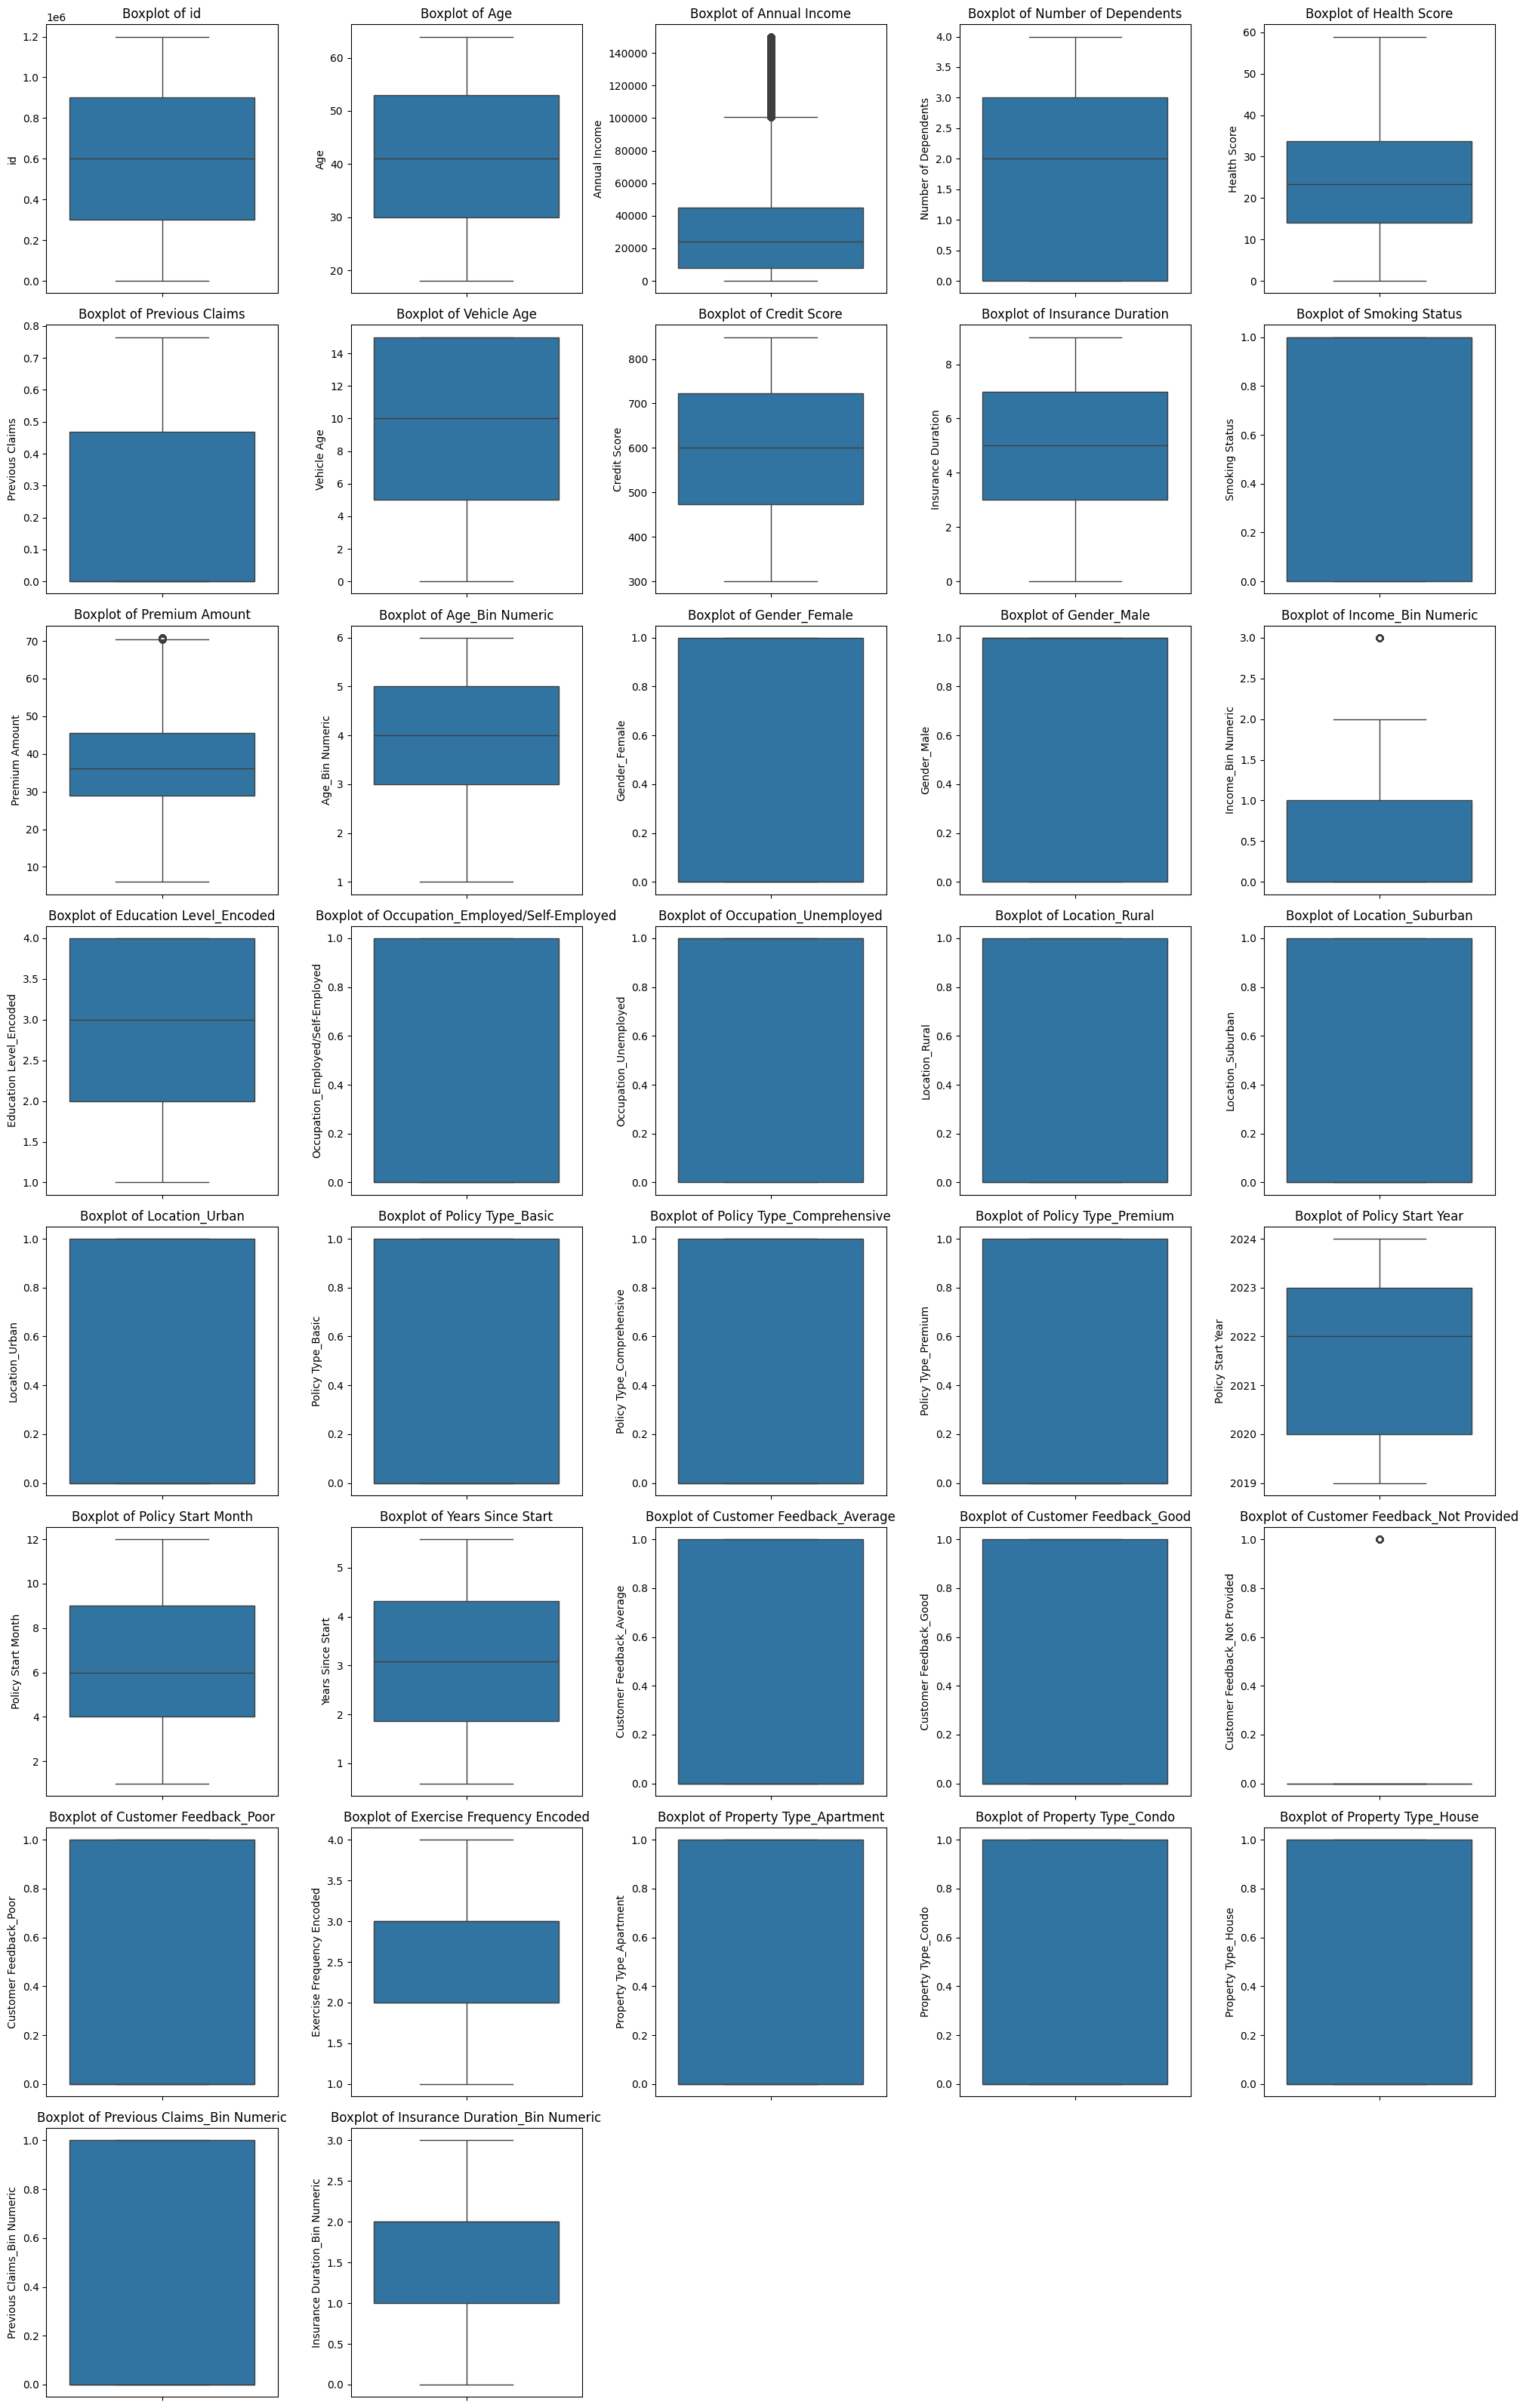

In [73]:
# Boxplots for outlier detection

# Get numerical columns
num_columns = insurance_train_data.select_dtypes(include=['number']).columns

# Define grid size (5 columns)
num_cols = 5
num_rows = (len(num_columns) // num_cols) + (len(num_columns) % num_cols > 0)

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 4 * num_rows))  # Adjust height based on the number of rows

# Loop through numerical columns and create boxplots
for i, col in enumerate(num_columns, 1):
    plt.subplot(num_rows, num_cols, i)  # Position plot in a 4x5 grid
    sns.boxplot(y=insurance_train_data[col])
    plt.title(f"Boxplot of {col}")
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Feature Selection

In [74]:
# Multicollinearity Check (VIF Analysis)
# Step 1: Prepare dataset (select numerical features only)
X = insurance_train_data.select_dtypes(include=['number']).drop(columns=['Premium Amount'])

# Step 2: Exclude one-hot encoded columns (e.g., columns related to "Gender" or other categorical variables)
one_hot_columns = [col for col in X.columns if 'Gender' in col or 'Marital Status' in col
                      or 'Occupation' in col or 'Location' in col or 'Policy Type' in col
                       or 'Customer Feedback' in col or 'Property Type' in col]  # Add more as needed
binned_columns = [col for col in X.columns if 'Bin' in col or 'Numeric' in col]  # Include binned features
time_related_columns = ['Policy Start Year', 'Years Since Start']  # Time-related features that may cause collinearity

# Combine all features to exclude
exclude_columns = one_hot_columns + binned_columns + time_related_columns

# Drop one-hot encoded columns
X = X.drop(columns=exclude_columns)

# Step 3: Add a constant column to the dataset (for intercept)
X_const = add_constant(X)

# Step 4: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Step 5: Display VIF results
print("VIF Analysis:\n", vif_data)

# Step 6: Identify features with high VIF (typically > 5 or 10)
high_vif = vif_data[vif_data['VIF'] > 5]  # or 10 depending on your threshold
print("\nFeatures with high VIF:\n", high_vif)

VIF Analysis:
                       Variable        VIF
0                        const  59.478027
1                           id   1.000007
2                          Age   1.000026
3                Annual Income   1.044218
4         Number of Dependents   1.000043
5                 Health Score   1.000712
6              Previous Claims   1.001988
7                  Vehicle Age   1.000028
8                 Credit Score   1.044025
9           Insurance Duration   1.000022
10              Smoking Status   1.000020
11     Education Level_Encoded   1.000020
12          Policy Start Month   1.000115
13  Exercise Frequency Encoded   1.000027

Features with high VIF:
   Variable        VIF
0    const  59.478027


In [75]:
# Correlation Analysis (v2)
# Select only numerical columns
num_features = insurance_train_data.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = num_features.corr()

# Identify highly correlated features (threshold > 0.9 or a threshold of your choice)
threshold = 0.9
highly_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            highly_corr_features.add(colname)

print(f"Highly correlated features (threshold {threshold}):\n", highly_corr_features)

Highly correlated features (threshold 0.9):
 {'Income_Bin Numeric', 'Age_Bin Numeric', 'Previous Claims_Bin Numeric', 'Occupation_Unemployed', 'Gender_Male', 'Years Since Start'}


In [76]:
# Feature Importance Using Random Forest
# Select only numerical columns
num_features = insurance_train_data.select_dtypes(include=['number'])

# Prepare the dataset (exclude target column and select only numerical features)
X = num_features.select_dtypes(include=['number']).drop(columns=['Premium Amount'])  # Select only numerical columns
y = num_features['Premium Amount']  # Target variable

# Train a Random Forest model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_features='sqrt')
rf.fit(X, y)

# Get feature importance scores
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

# Sort the features by importance
top_features = feature_importance.sort_values(ascending=False)

# Display top features
print("Top Features by Importance:\n", top_features.head(10))

Top Features by Importance:
 Credit Score            0.103112
Annual Income           0.097741
Health Score            0.092676
id                      0.083900
Years Since Start       0.081385
Age                     0.062483
Vehicle Age             0.048043
Policy Start Month      0.044102
Insurance Duration      0.037889
Number of Dependents    0.029792
dtype: float64


In [77]:
# Recursive Feature Elimination (RFE)
# Select only numerical columns
num_features = insurance_train_data.select_dtypes(include=['number'])

# Step 1: Prepare the dataset
X = num_features.drop(columns=['Premium Amount'])  # Features
y = num_features['Premium Amount']  # Target variable

# Step 3: Identify categorical columns for encoding
categorical_columns = X.select_dtypes(include=['object']).columns

# Create a column transformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), categorical_columns)],
    remainder='passthrough'  # Keep numerical columns as they are
)

# Step 3: Apply RFE for feature selection
# Create a pipeline with preprocessing and feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('scaler', StandardScaler()),  # Optional: Scale features before RFE
    ('feature_selection', RFE(LinearRegression(), n_features_to_select=10))  # RFE feature selection
])

# Fit the pipeline
pipeline.fit(X, y)

# Step 4: Get selected features
# Get the selected features after RFE
selected_features = X.columns[pipeline.named_steps['feature_selection'].support_]

print("Selected Features:\n", selected_features)

Selected Features:
 Index(['Annual Income', 'Previous Claims', 'Credit Score',
       'Income_Bin Numeric', 'Occupation_Unemployed', 'Policy Start Year',
       'Policy Start Month', 'Years Since Start',
       'Customer Feedback_Not Provided', 'Previous Claims_Bin Numeric'],
      dtype='object')


In [78]:
# Extract feature importance data
ranking = pipeline.named_steps['feature_selection'].ranking_
support = pipeline.named_steps['feature_selection'].support_

# Create DataFrame for analysis
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Selected': support,
    'Ranking': ranking
})

# Sort by ranking (1 = most important)
feature_df = feature_df.sort_values(by='Ranking')

# Display the full matrix
print("Feature Ranking Table:")
display(feature_df)  # Use in Jupyter Notebook for better output

# Highlight selected features
print("\nTop Selected Features:")
display(feature_df[feature_df['Selected'] == True])

Feature Ranking Table:


,Feature,Selected,Ranking
2,Annual Income,True,1
5,Previous Claims,True,1
7,Credit Score,True,1
13,Income_Bin Numeric,True,1
24,Policy Start Month,True,1
25,Years Since Start,True,1
23,Policy Start Year,True,1
16,Occupation_Unemployed,True,1
28,Customer Feedback_Not Provided,True,1
34,Previous Claims_Bin Numeric,True,1



Top Selected Features:


,Feature,Selected,Ranking
2,Annual Income,True,1
5,Previous Claims,True,1
7,Credit Score,True,1
13,Income_Bin Numeric,True,1
24,Policy Start Month,True,1
25,Years Since Start,True,1
23,Policy Start Year,True,1
16,Occupation_Unemployed,True,1
28,Customer Feedback_Not Provided,True,1
34,Previous Claims_Bin Numeric,True,1


Model Development & Evaluation
-----

#### Split the Data into Training and Test Sets

In [79]:
# Split the Data into Training and Test Sets (v2)
# Split the data into features (X) and target variable (y)
# Selected Features:
# Index(['Age', 'Annual Income', 'Previous Claims', 'Credit Score',
#        'Age_Bin Numeric', 'Income_Bin Numeric', 'Policy Start Year',
#        'Years Since Start', 'Customer Feedback_Not Provided',
#        'Previous Claims_Bin Numeric'],
#       dtype='object')
# The following feature was excluded as it did not make sense: Customer Feedback_Not Provided
X = insurance_train_data[['Age', 'Annual Income', 'Previous Claims', 'Credit Score',
                          'Age_Bin Numeric', 'Income_Bin Numeric', 'Policy Start Year', 
                          'Years Since Start', 'Previous Claims_Bin Numeric']]
y = insurance_train_data['Premium Amount']

# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline Models

In [80]:
# Basic Modeling via Multiple Linear Regression
# Train the model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predict on validation set
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

# Apply log transformation to actual and predicted values for training and test
log_y_train_true = np.log1p(y_train)  # log1p is equivalent to log(y + 1)
log_y_train_pred = np.log1p(y_train_pred)
log_y_test_true = np.log1p(y_test)
log_y_test_pred = np.log1p(y_test_pred)

# Calculate squared differences between the log-transformed actual and predicted values
train_squared_diff = (log_y_train_true - log_y_train_pred) ** 2
test_squared_diff = (log_y_test_true - log_y_test_pred) ** 2

# Evaluate the model on both training and test sets
train_mean_squared_diff = np.mean(train_squared_diff)
train_rmsle = np.sqrt(train_mean_squared_diff)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mean_squared_diff = np.mean(test_squared_diff)
test_rmsle = np.sqrt(test_mean_squared_diff)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics for both training and test sets
print("Training Set Evaluation:")
print(f"Mean Squared Error: {train_mse}")
print(f"R-squared: {train_r2}")
print(f"RMSLE: {train_rmsle}")

print("\nTest Set Evaluation:")
print(f"Mean Squared Error: {test_mse}")
print(f"R-squared: {test_r2}")
print(f"RMSLE: {test_rmsle}")

# RMSLE Value	Interpretation
# 0.0 - 0.2	Excellent – Predictions are very close to actual values.
# 0.2 - 0.5	Good – Model performs well, but some errors exist.
# 0.5 - 1.0	Moderate – The model makes significant errors. May need improvement.
# > 1.0	Poor – Large errors; model likely overfitting or missing key features.

Training Set Evaluation:
Mean Squared Error: 184.91404113383106
R-squared: 0.00917630503125566
RMSLE: 0.47140170390376634

Test Set Evaluation:
Mean Squared Error: 185.3016256200385
R-squared: 0.00879362007160911
RMSLE: 0.47250227456368893


#### Advanced Models

In [81]:
# Decision Tree
# Train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on training set
y_pred_train_dt = dt_model.predict(X_train)
# Predict on validation set (testing set)
y_pred_test_dt = dt_model.predict(X_test)

# Apply log transformation to actual and predicted values for training set
log_y_true_train_dt = np.log1p(y_train)  # log1p is equivalent to log(y + 1)
log_y_pred_train_dt = np.log1p(y_pred_train_dt)
# Apply log transformation to actual and predicted values for testing set
log_y_true_test_dt = np.log1p(y_test)
log_y_pred_test_dt = np.log1p(y_pred_test_dt)

# Calculate squared differences between the log-transformed actual and predicted values (training set)
squared_diff_train_dt = (log_y_true_train_dt - log_y_pred_train_dt) ** 2
# Calculate squared differences between the log-transformed actual and predicted values (testing set)
squared_diff_test_dt = (log_y_true_test_dt - log_y_pred_test_dt) ** 2

# Evaluate the model for training set
mean_squared_diff_train_dt = np.mean(squared_diff_train_dt)
rmsle_train_dt = np.sqrt(mean_squared_diff_train_dt)
mse_train_dt = mean_squared_error(y_train, y_pred_train_dt)
r2_train_dt = r2_score(y_train, y_pred_train_dt)
# Evaluate the model for testing set
mean_squared_diff_test_dt = np.mean(squared_diff_test_dt)
rmsle_test_dt = np.sqrt(mean_squared_diff_test_dt)
mse_test_dt = mean_squared_error(y_test, y_pred_test_dt)
r2_test_dt = r2_score(y_test, y_pred_test_dt)

# Print results
print(f"Decision Tree - Training MSE: {mse_train_dt}")
print(f"Decision Tree - Training R-squared: {r2_train_dt}")
print(f"Training RMSLE: {rmsle_train_dt}")

print(f"Decision Tree - Testing MSE: {mse_test_dt}")
print(f"Decision Tree - Testing R-squared: {r2_test_dt}")
print(f"Testing RMSLE: {rmsle_test_dt}")

Decision Tree - Training MSE: 0.0257776636001459
Decision Tree - Training R-squared: 0.999861875714038
Training RMSLE: 0.005687402361874336
Decision Tree - Testing MSE: 374.4159753604046
Decision Tree - Testing R-squared: -1.0028075969788528
Testing RMSLE: 0.6602510840912299


In [82]:
# Random Forest
# Train the model
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Optimized Random Forest (if needed)
# Train the model
rf_model = RandomForestRegressor(
    n_estimators=50,      # Reduce number of trees (default: 100)
    max_depth=6,          # Limit tree depth (prevents deep, slow trees)
    min_samples_split=10,  # Avoid unnecessary small splits
    min_samples_leaf=4,    # Avoid overfitting, improves efficiency
    max_features="sqrt",   # Use fewer features per split (reduces computation)
    bootstrap=True,        # Ensures faster training with sampling
    n_jobs=1,              # Avoids high CPU load (single-threaded)
    random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the training set
y_pred_train_rf = rf_model.predict(X_train)
# Predict on the test set
y_pred_test_rf = rf_model.predict(X_test)

# Apply log transformation to actual and predicted values for training set
log_y_true_train_rf = np.log1p(y_train)  # log1p is equivalent to log(y + 1)
log_y_pred_train_rf = np.log1p(y_pred_train_rf)
# Apply log transformation to actual and predicted values for test set
log_y_true_test_rf = np.log1p(y_test)
log_y_pred_test_rf = np.log1p(y_pred_test_rf)

# Calculate squared differences between the log-transformed actual and predicted values for training set
squared_diff_train_rf = (log_y_true_train_rf - log_y_pred_train_rf) ** 2
# Calculate squared differences between the log-transformed actual and predicted values for test set
squared_diff_test_rf = (log_y_true_test_rf - log_y_pred_test_rf) ** 2

# Evaluate the model on the training set
mean_squared_diff_train_rf = np.mean(squared_diff_train_rf)
rmsle_train_rf = np.sqrt(mean_squared_diff_train_rf)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
# Evaluate the model on the test set
mean_squared_diff_test_rf = np.mean(squared_diff_test_rf)
rmsle_test_rf = np.sqrt(mean_squared_diff_test_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# Print results
print(f"Random Forest - Training MSE: {mse_train_rf}")
print(f"Random Forest - Training R-squared: {r2_train_rf}")
print(f"Training RMSLE: {rmsle_train_rf}")

print(f"Random Forest - Testing MSE: {mse_test_rf}")
print(f"Random Forest - Testing R-squared: {r2_test_rf}")
print(f"Testing RMSLE: {rmsle_test_rf}")

Random Forest - Training MSE: 179.55403470428467
Random Forest - Training R-squared: 0.03789679236155907
Training RMSLE: 0.4646315542918868
Random Forest - Testing MSE: 179.98005079215227
Random Forest - Testing R-squared: 0.03725952749696049
Testing RMSLE: 0.4658704646094586


In [83]:
# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
# params = {
#     'objective': 'reg:squarederror', 
#     'eval_metric': 'rmse', 
#     'max_depth': 6, 
#     'eta': 0.1
# }
# Optimized XGBoost parameters (if needed)
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'max_depth': 4,         # Reduce tree depth (less memory usage)
    'eta': 0.2,             # Faster learning rate (reduces rounds needed)
    'subsample': 0.8,       # Use 80% of data per boosting round (less computation)
    'colsample_bytree': 0.8 # Use 80% of features per tree (faster training)
}

# Reduce boosting rounds
num_boost_round = 50  # Reduce from 100 to 50
# num_boost_round = 100

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Make predictions
y_pred_xgb = xgb_model.predict(dtest)
# Make predictions on the train set (for RMSLE calculation on training data)
y_pred_xgb_train = xgb_model.predict(dtrain)

# Evaluate the model on the test set
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

# Calculate RMLSE for the test set
log_y_true_xgb = np.log1p(y_test)  # log1p is log(y + 1)
log_y_pred_xgb = np.log1p(y_pred_xgb)

# Squared differences between log-transformed actual and predicted values (test set)
squared_diff_xgb = (log_y_true_xgb - log_y_pred_xgb) ** 2

# Mean squared difference and RMSLE for the test set
mean_squared_diff_xgb = np.mean(squared_diff_xgb)
rmsle_xgb_test = np.sqrt(mean_squared_diff_xgb)

# Evaluate the model on the train set
mse_xgb_train = mean_squared_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)

# Calculate RMLSE for the train set
log_y_true_xgb_train = np.log1p(y_train)  # log1p is log(y + 1)
log_y_pred_xgb_train = np.log1p(y_pred_xgb_train)

# Squared differences between log-transformed actual and predicted values (train set)
squared_diff_xgb_train = (log_y_true_xgb_train - log_y_pred_xgb_train) ** 2

# Mean squared difference and RMSLE for the train set
mean_squared_diff_xgb_train = np.mean(squared_diff_xgb_train)
rmsle_xgb_train = np.sqrt(mean_squared_diff_xgb_train)

# Print results
print(f"XGBoost Test MSE: {mse_xgb_test}")
print(f"XGBoost Test R-squared: {r2_xgb_test}")
print(f"XGBoost Test RMSLE: {rmsle_xgb_test}")

print(f"XGBoost Train MSE: {mse_xgb_train}")
print(f"XGBoost Train R-squared: {r2_xgb_train}")
print(f"XGBoost Train RMSLE: {rmsle_xgb_train}")

XGBoost Test MSE: 179.71247595680464
XGBoost Test R-squared: 0.03869082570072635
XGBoost Test RMSLE: 0.4654407429199889
XGBoost Train MSE: 179.19570658818637
XGBoost Train R-squared: 0.03981681955812422
XGBoost Train RMSLE: 0.4641039906029737


#### Hyperparameter Tuning

In [84]:
# Define models and hyperparameter grids
# We modified the settings for standard laptop use
models = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'max_depth': [3, 6],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt'], # ['auto', 'sqrt', 'log2'],
            'criterion': ['squared_error'] # ['squared_error', 'absolute_error']
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt'], # ['auto', 'sqrt', 'log2'],
            'bootstrap': [True] # [True, False]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
        "params": {
            'max_depth': [3, 6],
            'eta': [0.1, 0.2],
            'n_estimators': [50, 100],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 0.1]
        }
    }
}

# Dictionary to store results
results_rsc = {}

# Perform RandomizedSearchCV and evaluate each model
for name, config in models.items():
    print(f"Training {name}...")

    random_search = RandomizedSearchCV(
        config["model"], param_distributions=config["params"], 
        n_iter=min(10, len(ParameterGrid(config["params"]))),  # Adjust n_iter automatically
        cv=3, verbose=2, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    
    # Predict and evaluate
    y_pred_rsc = best_model.predict(X_test)
    rmse_rsc = np.sqrt(mean_squared_error(y_test, y_pred_rsc))
    r2_rsc = r2_score(y_test, y_pred_rsc)
    rmsle_rsc = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_rsc)))
    
    # Store results
    results_rsc[name] = {
        "Best Parameters": random_search.best_params_,
        "RMSE": rmse_rsc,
        "RMSLE": rmsle_rsc,
        "R-squared": r2_rsc
    }

# Print results for all models
for name, metrics in results_rsc.items():
    print(f"\n{name} Results:")
    print(f"Best Parameters: {metrics['Best Parameters']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"RMSLE: {metrics['RMSLE']}")
    print(f"R-squared: {metrics['R-squared']}")

Training Decision Tree...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Training Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Decision Tree Results:
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'squared_error'}
RMSE: 13.467007387307165
RMSLE: 0.4675707029107024
R-squared: 0.02987643038862786

Random Forest Results:
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': True}
RMSE: 13.417428748126161
RMSLE: 0.4659722004214911
R-squared: 0.03700628039945408

XGBoost Results:
Best Parameters: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 6, 'gamma': 0.1, 'eta': 0.1, 'colsample_bytree': 1.0}
RMSE: 13.40118747257878
RMSLE: 0.4652853643060961
R-squared: 0.039336202277775234


#### Evaluation Metrics

In [86]:
# Evaluate the models

# Output metrics for comparison
print(f"Linear Regression - RMSLE: {test_rmsle}")
print(f"Decision Tree - RMSLE: {rmsle_test_dt}")
print(f"Random Forest - RMSLE: {rmsle_test_rf}")
print(f"XGBoost - RMSLE: {rmsle_xgb_test}")
for name, metrics in results_rsc.items():
    print(f"RandomizedSearchCV - {name} - RMSLE: {metrics['RMSLE']}")

Linear Regression - RMSLE: 0.47250227456368893
Decision Tree - RMSLE: 0.6602510840912299
Random Forest - RMSLE: 0.4658704646094586
XGBoost - RMSLE: 0.4654407429199889
RandomizedSearchCV - Decision Tree - RMSLE: 0.4675707029107024
RandomizedSearchCV - Random Forest - RMSLE: 0.4659722004214911
RandomizedSearchCV - XGBoost - RMSLE: 0.4652853643060961


#### Save the Best Model

In [87]:
import joblib

# Save the best model
joblib.dump(best_model, 'kaggle/working/health-insurance-premium-best-model.pkl')
print("Model saved successfully!")

Model saved successfully!
